In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0, '/Users/ammar.tareen/Desktop/Research_projects/mavenn2/')
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
def get_titeseq_replicate_df(replicate_number='1'):

    data_df_full = pd.read_csv(f'data/replicate_{replicate_number}.csv',index_col=[0])
    y_cols = list(data_df_full.columns[14:58])
    cols = y_cols.copy()
    # Currently concatenating CDR1-H and CDR3-H sequencnes. Not sure if correct.
    data_df_full['x'] = (data_df_full['CDR1H_AA']+data_df_full['CDR3H_AA']).values
    cols.insert(0,'x')
    data_df = data_df_full[cols].copy()
    
    return data_df
    

In [3]:
replicate_1_df = get_titeseq_replicate_df('1')
replicate_2_df = get_titeseq_replicate_df('2')
replicate_3_df = get_titeseq_replicate_df('3')

data_df = replicate_1_df.append(replicate_2_df, ignore_index=True).append(replicate_3_df, ignore_index=True).reset_index(drop=True).copy()


In [4]:
data_df_full_rep_1 = pd.read_csv(f'data/replicate_1.csv',index_col=[0])
y_cols = list(data_df_full_rep_1.columns[14:58])
X = data_df['x']
y = data_df[y_cols]

In [5]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [6]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y',]


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=20, Y=44


In [7]:
#!ls /Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn/mavenn/development_mavenn2/Titeseq_16

In [8]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet,theta_regularization=0.001)

# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



2022-08-16 08:18:16.163767: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Initialize at discrete monotonic GP map

In [9]:
gpmap.set_params()
theta_0_init = np.load('models/theta_0_DM.npy')
theta_lc_init = np.load('models/theta_lc_DM.npy')

init_params_dict = {'theta_0':theta_0_init, 'theta_lc':theta_lc_init}
#gpmap.set_params(**init_params_dict)

In [10]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [11]:
print(N_y[0:10])

fluorescein0bin0          15885950
fluorescein0bin1            845949
fluorescein0bin2          14646947
fluorescein0bin3            480168
fluorescein10^-5.5bin0     4938811
fluorescein10^-5.5bin1     3558812
fluorescein10^-5.5bin2     7335952
fluorescein10^-5.5bin3     7306329
fluorescein10^-5bin0      12323072
fluorescein10^-5bin1       1386792
dtype: int64


#### I obtained these values from Fig 3's script

In [12]:
bin_vals_16_4_15 = np.array([[1.4775788014225415, 2.245106453825187],
[2.2459637507318497, 2.9683536647430646],
[2.96837636283699, 3.6663288893768895],
[3.6675170811229103, np.log10(3e4)]])

#April 19 gates
bin_vals_16_4_19 = np.array([[1.4775788014225415, 2.245106453825187],
[2.2459637507318497, 2.85027248745035],
[2.8650326346119392, 3.474446976276228],
[3.4849588153986915, np.log10(1e5)]])

#April 21 gates
bin_vals_16_4_21 = np.array([[1.4775788014225415,2.200826012340419],
[2.216443456408671,2.8355123402887603],
[2.8355123402887603,3.474446976276228],
[3.4849588153986915,np.log10(3e4)]])

aff_gates = [bin_vals_16_4_15, bin_vals_16_4_19, bin_vals_16_4_21]

In [13]:
np.mean(np.array(aff_gates),axis=0)

array([[1.4775788 , 2.23034631],
       [2.23612365, 2.88471283],
       [2.88964045, 3.53840761],
       [3.54581157, 4.65141417]])

In [14]:
#bounds = np.array([[0,180],[180,1400],[1400,10500],[10500,250000]])
bounds = np.mean(np.array(aff_gates),axis=0)
bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,1.477579,2.230346
1,2.236124,2.884713
2,2.889640,3.538408
3,3.545812,4.651414


In [15]:
# mu_neg = np.log(200)
# mu_pos = np.log(9000)

#mu_neg = np.log(1.2)
mu_neg = np.log10(200)
#mu_neg = np.log(50)
#mu_pos = np.log10(9000)

#mu_pos = np.log10(9000)

# mu_pos = 10 # kinda works well
# mu_pos = 7.5 trains well but scale is wrong
# mu_pos = 5 # kinda works well
## mu_pos = 3.0 # MPs don't lookf fully converged but kd scale looks nice. WT seq is kinda off.
# mu_pos = 3.5 this may be the best, nice rotated kd values.
#mu_pos = 3.75 # could use as seed to and vary mu neg
# mu_pos = 4.0 # quite close
# mu_pos = 4.5 # quite close

mu_neg = 1.5
mu_pos = 3.8


sigma_neg = 2.2
sigma_pos = 2.0

In [16]:
a = np.log10(10**(mu_pos) - 10**mu_neg)

In [17]:
mu_neg, mu_pos

(1.5, 3.8)

In [18]:
np.log10(10000)

4.0

In [19]:
a

3.797817898714678

In [20]:
f_y_upper_bounds

array([2.23034631, 2.88471283, 3.53840761, 4.65141417])

In [21]:
replicate_1_df.columns

Index(['x', 'fluorescein0bin0', 'fluorescein0bin1', 'fluorescein0bin2',
       'fluorescein0bin3', 'fluorescein10^-5.5bin0', 'fluorescein10^-5.5bin1',
       'fluorescein10^-5.5bin2', 'fluorescein10^-5.5bin3',
       'fluorescein10^-5bin0', 'fluorescein10^-5bin1', 'fluorescein10^-5bin2',
       'fluorescein10^-5bin3', 'fluorescein10^-6.5bin0',
       'fluorescein10^-6.5bin1', 'fluorescein10^-6.5bin2',
       'fluorescein10^-6.5bin3', 'fluorescein10^-6bin0',
       'fluorescein10^-6bin1', 'fluorescein10^-6bin2', 'fluorescein10^-6bin3',
       'fluorescein10^-7.5bin0', 'fluorescein10^-7.5bin1',
       'fluorescein10^-7.5bin2', 'fluorescein10^-7.5bin3',
       'fluorescein10^-7bin0', 'fluorescein10^-7bin1', 'fluorescein10^-7bin2',
       'fluorescein10^-7bin3', 'fluorescein10^-8.5bin0',
       'fluorescein10^-8.5bin1', 'fluorescein10^-8.5bin2',
       'fluorescein10^-8.5bin3', 'fluorescein10^-8bin0',
       'fluorescein10^-8bin1', 'fluorescein10^-8bin2', 'fluorescein10^-8bin3',
       'fl

In [22]:
#np.arange(10**(-13),10**(-6),10**(-12))
# cs = [0,10**(-9.5),
#      10**(-9),10**(-8.5),
#      10**(-8),10**(-7.5),
#      10**(-7),10**(-6.5),
#      10**(-6),10**(-5.5),
#      10**(-5),]

cs2 = [0,10**(-5.5),
     10**(-5),10**(-6.5),
     10**(-6),10**(-7.5),
     10**(-7),10**(-8.5),
     10**(-8),10**(-9.5),
     10**(-9),]


In [23]:
order_of_mps = [0,9,10,7,8,5,6,3,4,1,2]

In [24]:
# a = 10.0 is too high
# a = 5.0 doesn't seem to work either
# a = 1, 2.5 seems a bit better with kd, but measurement process dont appear to be converged.
# a = 4 is reasonable with kd R^2 ~ 0.183
# a = 4.5 kd R^2 = 0.006
# a = 3.5 kd R^2 = 0.049

In [25]:
TiteSeq_mp_list = [mavenn.measurement_process_layers.TiteSeqMP(N_y=N_y[4*mp_idx:4*mp_idx+4],
                                                         #c=cs[mp_idx],      
                                                         c=cs2[mp_idx],
                                                         a=a,
                                                         Y=4,
                                                         mu_pos=mu_pos,
                                                         sigma_pos=sigma_pos,
                                                         mu_neg=mu_neg,
                                                         sigma_neg=sigma_neg,
                                                         f_y_lower_bounds=f_y_lower_bounds,
                                                         f_y_upper_bounds=f_y_upper_bounds,
                                                         info_for_layers_dict={'H_y_norm':0},
                                                         eta=1e-5,)
           for mp_idx in range(len(y_cols)//4)
          ]

In [26]:
len(TiteSeq_mp_list)

11

In [27]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=TiteSeq_mp_list)

In [28]:
#model.model.summary()

In [29]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols[0:4]].values,
                       y_train[y_cols[4:8]].values,
                       y_train[y_cols[8:12]].values,
                       y_train[y_cols[12:16]].values,
                       y_train[y_cols[16:20]].values,
                       y_train[y_cols[20:24]].values,
                       y_train[y_cols[24:28]].values,
                       y_train[y_cols[28:32]].values,
                       y_train[y_cols[32:36]].values,
                       y_train[y_cols[36:40]].values,
                       y_train[y_cols[40:44]].values,                                                        
                      ],

               shuffle=False)

N = 10,487 observations set as training data.
Using 20.2% for validation.
Time to set data: 0.483 sec.


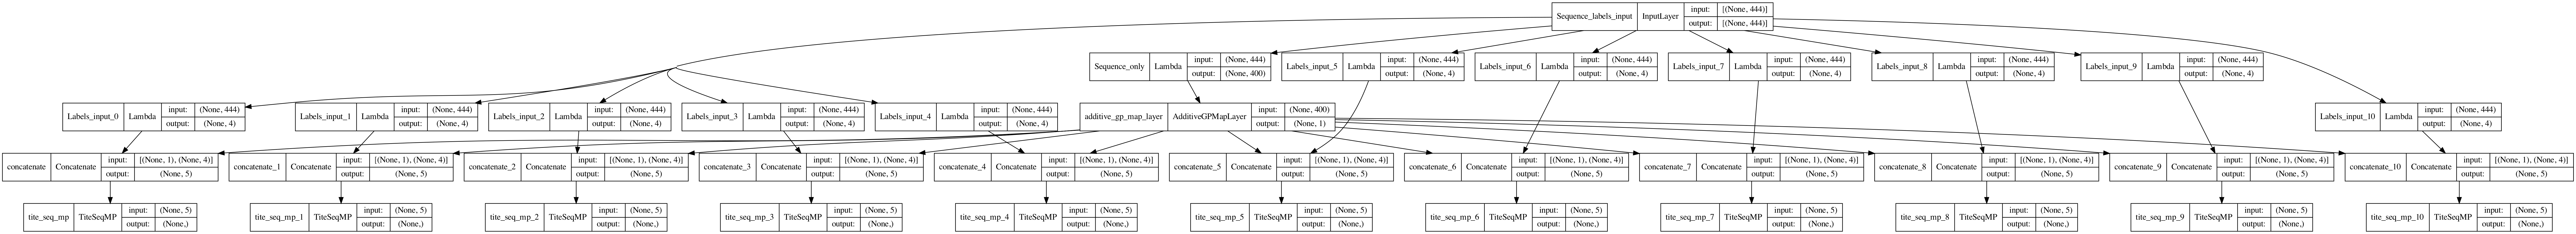

In [30]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=200,to_file='pngs/Titeseq_MP/titeseq16_TSMP.png')


In [31]:

# Fit model to data
model.fit(learning_rate=.001,
          epochs=1000,
          batch_size=200,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=100,
          linear_initialization=False)

Epoch 1/1000
42/42 [==============================] - 9s 37ms/step - loss: 9573780.0000 - tite_seq_mp_loss: 675787.9375 - tite_seq_mp_1_loss: 784940.5625 - tite_seq_mp_2_loss: 1370194.0000 - tite_seq_mp_3_loss: 967343.0000 - tite_seq_mp_4_loss: 660190.0625 - tite_seq_mp_5_loss: 355728.4375 - tite_seq_mp_6_loss: 435062.9688 - tite_seq_mp_7_loss: 1285941.2500 - tite_seq_mp_8_loss: 808340.3750 - tite_seq_mp_9_loss: 1205926.1250 - tite_seq_mp_10_loss: 1024323.8125 - I_var: -0.2898 - val_loss: 4478202.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 402325.4062 - val_tite_seq_mp_2_loss: 704068.0625 - val_tite_seq_mp_3_loss: 453544.2812 - val_tite_seq_mp_4_loss: 313040.0312 - val_tite_seq_mp_5_loss: 192374.4531 - val_tite_seq_mp_6_loss: 217045.7969 - val_tite_seq_mp_7_loss: 489892.1250 - val_tite_seq_mp_8_loss: 342351.0938 - val_tite_seq_mp_9_loss: 525963.3125 - val_tite_seq_mp_10_loss: 453664.2812 - val_I_var: -0.2472
Epoch 2/1000
42/42 [==============================] - 0

Epoch 10/1000
42/42 [==============================] - 0s 5ms/step - loss: 8402713.0000 - tite_seq_mp_loss: 677699.2500 - tite_seq_mp_1_loss: 600422.0000 - tite_seq_mp_2_loss: 1075156.3750 - tite_seq_mp_3_loss: 652770.1250 - tite_seq_mp_4_loss: 461556.8125 - tite_seq_mp_5_loss: 324071.6562 - tite_seq_mp_6_loss: 362016.6562 - tite_seq_mp_7_loss: 1256316.3750 - tite_seq_mp_8_loss: 771584.2500 - tite_seq_mp_9_loss: 1202953.3750 - tite_seq_mp_10_loss: 1018166.4375 - I_var: -0.2787 - val_loss: 4163101.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 354808.8125 - val_tite_seq_mp_2_loss: 667422.6875 - val_tite_seq_mp_3_loss: 354561.3125 - val_tite_seq_mp_4_loss: 273462.4375 - val_tite_seq_mp_5_loss: 175698.6875 - val_tite_seq_mp_6_loss: 177279.1875 - val_tite_seq_mp_7_loss: 477630.6250 - val_tite_seq_mp_8_loss: 323360.0000 - val_tite_seq_mp_9_loss: 524380.3125 - val_tite_seq_mp_10_loss: 450563.6562 - val_I_var: -0.2328
Epoch 11/1000
42/42 [==============================] - 

Epoch 19/1000
42/42 [==============================] - 0s 5ms/step - loss: 7484701.5000 - tite_seq_mp_loss: 677627.6250 - tite_seq_mp_1_loss: 659626.2500 - tite_seq_mp_2_loss: 1187605.8750 - tite_seq_mp_3_loss: 693759.0000 - tite_seq_mp_4_loss: 504292.5312 - tite_seq_mp_5_loss: 275012.9062 - tite_seq_mp_6_loss: 337025.3438 - tite_seq_mp_7_loss: 834737.1875 - tite_seq_mp_8_loss: 552764.6875 - tite_seq_mp_9_loss: 969736.3125 - tite_seq_mp_10_loss: 792513.9375 - I_var: 0.0422 - val_loss: 4233524.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 409746.3125 - val_tite_seq_mp_2_loss: 758950.5000 - val_tite_seq_mp_3_loss: 471559.6875 - val_tite_seq_mp_4_loss: 342886.0312 - val_tite_seq_mp_5_loss: 175308.3906 - val_tite_seq_mp_6_loss: 187177.1094 - val_tite_seq_mp_7_loss: 381776.0625 - val_tite_seq_mp_8_loss: 278696.5938 - val_tite_seq_mp_9_loss: 452222.3750 - val_tite_seq_mp_10_loss: 391267.3125 - val_I_var: 0.0380
Epoch 20/1000
42/42 [==============================] - 0s 5m

Epoch 28/1000
42/42 [==============================] - 0s 5ms/step - loss: 7253036.0000 - tite_seq_mp_loss: 677274.9375 - tite_seq_mp_1_loss: 658011.1250 - tite_seq_mp_2_loss: 1183881.3750 - tite_seq_mp_3_loss: 693636.5000 - tite_seq_mp_4_loss: 502640.4062 - tite_seq_mp_5_loss: 277016.5625 - tite_seq_mp_6_loss: 338581.0000 - tite_seq_mp_7_loss: 799821.0000 - tite_seq_mp_8_loss: 544337.4375 - tite_seq_mp_9_loss: 855005.7500 - tite_seq_mp_10_loss: 722830.4375 - I_var: 0.1230 - val_loss: 4174799.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 407388.6250 - val_tite_seq_mp_2_loss: 754411.1875 - val_tite_seq_mp_3_loss: 465758.4375 - val_tite_seq_mp_4_loss: 339323.4375 - val_tite_seq_mp_5_loss: 175787.5781 - val_tite_seq_mp_6_loss: 186795.8750 - val_tite_seq_mp_7_loss: 375377.0938 - val_tite_seq_mp_8_loss: 277817.3438 - val_tite_seq_mp_9_loss: 428355.9062 - val_tite_seq_mp_10_loss: 379849.5938 - val_I_var: 0.0905
Epoch 29/1000
42/42 [==============================] - 0s 5m

Epoch 37/1000
42/42 [==============================] - 0s 5ms/step - loss: 7139412.5000 - tite_seq_mp_loss: 677780.4375 - tite_seq_mp_1_loss: 648757.0000 - tite_seq_mp_2_loss: 1166099.7500 - tite_seq_mp_3_loss: 663015.9375 - tite_seq_mp_4_loss: 487491.9688 - tite_seq_mp_5_loss: 269832.2812 - tite_seq_mp_6_loss: 331696.7500 - tite_seq_mp_7_loss: 790121.3750 - tite_seq_mp_8_loss: 535313.0625 - tite_seq_mp_9_loss: 851157.6875 - tite_seq_mp_10_loss: 718147.3125 - I_var: 0.1421 - val_loss: 4070750.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 398812.2812 - val_tite_seq_mp_2_loss: 738995.0000 - val_tite_seq_mp_3_loss: 436462.5312 - val_tite_seq_mp_4_loss: 325923.0312 - val_tite_seq_mp_5_loss: 169091.1406 - val_tite_seq_mp_6_loss: 179955.1719 - val_tite_seq_mp_7_loss: 364967.4375 - val_tite_seq_mp_8_loss: 268689.5312 - val_tite_seq_mp_9_loss: 428102.8750 - val_tite_seq_mp_10_loss: 375817.7500 - val_I_var: 0.1103
Epoch 38/1000
42/42 [==============================] - 0s 5m

Epoch 46/1000
42/42 [==============================] - 0s 5ms/step - loss: 7026501.5000 - tite_seq_mp_loss: 676776.4375 - tite_seq_mp_1_loss: 638117.0625 - tite_seq_mp_2_loss: 1143319.0000 - tite_seq_mp_3_loss: 637935.3125 - tite_seq_mp_4_loss: 473127.4375 - tite_seq_mp_5_loss: 265496.5625 - tite_seq_mp_6_loss: 326626.5625 - tite_seq_mp_7_loss: 783719.5000 - tite_seq_mp_8_loss: 529081.6250 - tite_seq_mp_9_loss: 841200.1875 - tite_seq_mp_10_loss: 711101.5000 - I_var: 0.1576 - val_loss: 3979592.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 389104.6875 - val_tite_seq_mp_2_loss: 719544.1250 - val_tite_seq_mp_3_loss: 410757.8750 - val_tite_seq_mp_4_loss: 312568.5000 - val_tite_seq_mp_5_loss: 164648.7969 - val_tite_seq_mp_6_loss: 174590.0938 - val_tite_seq_mp_7_loss: 359131.6875 - val_tite_seq_mp_8_loss: 263034.8750 - val_tite_seq_mp_9_loss: 428330.6250 - val_tite_seq_mp_10_loss: 373947.7812 - val_I_var: 0.1197
Epoch 47/1000
42/42 [==============================] - 0s 5m

Epoch 55/1000
42/42 [==============================] - 0s 5ms/step - loss: 6942202.0000 - tite_seq_mp_loss: 677537.6250 - tite_seq_mp_1_loss: 629600.6250 - tite_seq_mp_2_loss: 1122176.5000 - tite_seq_mp_3_loss: 621249.0625 - tite_seq_mp_4_loss: 462322.7812 - tite_seq_mp_5_loss: 263258.8125 - tite_seq_mp_6_loss: 323706.0625 - tite_seq_mp_7_loss: 781501.1875 - tite_seq_mp_8_loss: 526484.1875 - tite_seq_mp_9_loss: 830059.4375 - tite_seq_mp_10_loss: 704305.9375 - I_var: 0.1677 - val_loss: 3909980.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 380801.0938 - val_tite_seq_mp_2_loss: 701432.8125 - val_tite_seq_mp_3_loss: 393518.0312 - val_tite_seq_mp_4_loss: 302336.3438 - val_tite_seq_mp_5_loss: 162441.6094 - val_tite_seq_mp_6_loss: 171437.5938 - val_tite_seq_mp_7_loss: 356071.3438 - val_tite_seq_mp_8_loss: 260240.2344 - val_tite_seq_mp_9_loss: 425739.3438 - val_tite_seq_mp_10_loss: 372027.8125 - val_I_var: 0.1289
Epoch 56/1000
42/42 [==============================] - 0s 5m

Epoch 64/1000
42/42 [==============================] - 0s 5ms/step - loss: 6872004.0000 - tite_seq_mp_loss: 677581.0625 - tite_seq_mp_1_loss: 620510.5625 - tite_seq_mp_2_loss: 1098140.1250 - tite_seq_mp_3_loss: 605538.8750 - tite_seq_mp_4_loss: 451473.3750 - tite_seq_mp_5_loss: 261525.2188 - tite_seq_mp_6_loss: 321074.5000 - tite_seq_mp_7_loss: 780381.5000 - tite_seq_mp_8_loss: 524787.6250 - tite_seq_mp_9_loss: 827525.8125 - tite_seq_mp_10_loss: 703465.8125 - I_var: 0.1665 - val_loss: 3847816.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 372406.2500 - val_tite_seq_mp_2_loss: 682180.1250 - val_tite_seq_mp_3_loss: 378271.6562 - val_tite_seq_mp_4_loss: 292532.5938 - val_tite_seq_mp_5_loss: 160706.4688 - val_tite_seq_mp_6_loss: 168747.4531 - val_tite_seq_mp_7_loss: 354179.0625 - val_tite_seq_mp_8_loss: 258295.8438 - val_tite_seq_mp_9_loss: 425166.3750 - val_tite_seq_mp_10_loss: 371397.0938 - val_I_var: 0.1321
Epoch 65/1000
42/42 [==============================] - 0s 5m

Epoch 73/1000
42/42 [==============================] - 0s 5ms/step - loss: 6810614.5000 - tite_seq_mp_loss: 677589.1875 - tite_seq_mp_1_loss: 615085.8125 - tite_seq_mp_2_loss: 1082788.6250 - tite_seq_mp_3_loss: 598224.1875 - tite_seq_mp_4_loss: 445755.2188 - tite_seq_mp_5_loss: 260908.9688 - tite_seq_mp_6_loss: 320015.6875 - tite_seq_mp_7_loss: 780552.6875 - tite_seq_mp_8_loss: 523382.3750 - tite_seq_mp_9_loss: 813170.0000 - tite_seq_mp_10_loss: 693140.8750 - I_var: 0.1727 - val_loss: 3799749.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 365731.8750 - val_tite_seq_mp_2_loss: 665925.3750 - val_tite_seq_mp_3_loss: 367669.8125 - val_tite_seq_mp_4_loss: 285120.1250 - val_tite_seq_mp_5_loss: 159765.5938 - val_tite_seq_mp_6_loss: 167041.7500 - val_tite_seq_mp_7_loss: 353093.7188 - val_tite_seq_mp_8_loss: 257286.2812 - val_tite_seq_mp_9_loss: 423585.2500 - val_tite_seq_mp_10_loss: 370595.4688 - val_I_var: 0.1359
Epoch 74/1000
42/42 [==============================] - 0s 6m

Epoch 82/1000
42/42 [==============================] - 0s 5ms/step - loss: 6763760.0000 - tite_seq_mp_loss: 677693.8750 - tite_seq_mp_1_loss: 608619.0000 - tite_seq_mp_2_loss: 1064751.1250 - tite_seq_mp_3_loss: 588782.7500 - tite_seq_mp_4_loss: 438677.4375 - tite_seq_mp_5_loss: 260154.4844 - tite_seq_mp_6_loss: 318636.1562 - tite_seq_mp_7_loss: 780007.7500 - tite_seq_mp_8_loss: 522677.9688 - tite_seq_mp_9_loss: 811208.5625 - tite_seq_mp_10_loss: 692549.8750 - I_var: 0.1791 - val_loss: 3759079.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 359760.5625 - val_tite_seq_mp_2_loss: 650992.8125 - val_tite_seq_mp_3_loss: 358520.3438 - val_tite_seq_mp_4_loss: 278517.6562 - val_tite_seq_mp_5_loss: 159112.9219 - val_tite_seq_mp_6_loss: 165639.4219 - val_tite_seq_mp_7_loss: 352564.4062 - val_tite_seq_mp_8_loss: 256730.8594 - val_tite_seq_mp_9_loss: 422931.4688 - val_tite_seq_mp_10_loss: 370374.7812 - val_I_var: 0.1371
Epoch 83/1000
42/42 [==============================] - 0s 5m

Epoch 91/1000
42/42 [==============================] - 0s 5ms/step - loss: 6731273.0000 - tite_seq_mp_loss: 677650.7500 - tite_seq_mp_1_loss: 605457.3750 - tite_seq_mp_2_loss: 1054821.3750 - tite_seq_mp_3_loss: 584859.5000 - tite_seq_mp_4_loss: 435362.6250 - tite_seq_mp_5_loss: 259962.6875 - tite_seq_mp_6_loss: 318333.4375 - tite_seq_mp_7_loss: 783010.0000 - tite_seq_mp_8_loss: 522681.3438 - tite_seq_mp_9_loss: 802948.5000 - tite_seq_mp_10_loss: 686183.3750 - I_var: 0.1848 - val_loss: 3732485.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 356494.4062 - val_tite_seq_mp_2_loss: 642241.5000 - val_tite_seq_mp_3_loss: 354237.5625 - val_tite_seq_mp_4_loss: 275085.4688 - val_tite_seq_mp_5_loss: 158882.1562 - val_tite_seq_mp_6_loss: 165074.0938 - val_tite_seq_mp_7_loss: 351921.8125 - val_tite_seq_mp_8_loss: 256350.4844 - val_tite_seq_mp_9_loss: 419481.4688 - val_tite_seq_mp_10_loss: 368781.9375 - val_I_var: 0.1444
Epoch 92/1000
42/42 [==============================] - 0s 5m

Epoch 100/1000
42/42 [==============================] - 0s 5ms/step - loss: 6693522.0000 - tite_seq_mp_loss: 677226.2500 - tite_seq_mp_1_loss: 599643.0000 - tite_seq_mp_2_loss: 1039066.4375 - tite_seq_mp_3_loss: 576499.3125 - tite_seq_mp_4_loss: 428924.3750 - tite_seq_mp_5_loss: 259559.2188 - tite_seq_mp_6_loss: 317025.6250 - tite_seq_mp_7_loss: 781112.2500 - tite_seq_mp_8_loss: 522056.6562 - tite_seq_mp_9_loss: 804608.7500 - tite_seq_mp_10_loss: 687798.6250 - I_var: 0.1885 - val_loss: 3703267.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 351894.7188 - val_tite_seq_mp_2_loss: 630828.8125 - val_tite_seq_mp_3_loss: 347159.3125 - val_tite_seq_mp_4_loss: 269858.3750 - val_tite_seq_mp_5_loss: 158574.7969 - val_tite_seq_mp_6_loss: 164118.2188 - val_tite_seq_mp_7_loss: 351897.1250 - val_tite_seq_mp_8_loss: 256252.1562 - val_tite_seq_mp_9_loss: 419699.9062 - val_tite_seq_mp_10_loss: 369049.6562 - val_I_var: 0.1433
Epoch 101/1000
42/42 [==============================] - 0s 

Epoch 109/1000
42/42 [==============================] - 0s 6ms/step - loss: 6669919.0000 - tite_seq_mp_loss: 677584.1250 - tite_seq_mp_1_loss: 597279.5000 - tite_seq_mp_2_loss: 1032056.4375 - tite_seq_mp_3_loss: 573384.8750 - tite_seq_mp_4_loss: 426249.1250 - tite_seq_mp_5_loss: 259546.2500 - tite_seq_mp_6_loss: 316804.5312 - tite_seq_mp_7_loss: 782765.5625 - tite_seq_mp_8_loss: 522000.9688 - tite_seq_mp_9_loss: 798037.9375 - tite_seq_mp_10_loss: 684208.2500 - I_var: 0.1947 - val_loss: 3681990.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 348879.8750 - val_tite_seq_mp_2_loss: 623316.2500 - val_tite_seq_mp_3_loss: 342783.0312 - val_tite_seq_mp_4_loss: 266468.0625 - val_tite_seq_mp_5_loss: 158438.5000 - val_tite_seq_mp_6_loss: 163592.6406 - val_tite_seq_mp_7_loss: 351700.0312 - val_tite_seq_mp_8_loss: 256130.0312 - val_tite_seq_mp_9_loss: 418286.0312 - val_tite_seq_mp_10_loss: 368461.2812 - val_I_var: 0.1460
Epoch 110/1000
42/42 [==============================] - 0s 

Epoch 118/1000
42/42 [==============================] - 0s 9ms/step - loss: 6648551.0000 - tite_seq_mp_loss: 677688.7500 - tite_seq_mp_1_loss: 594181.8125 - tite_seq_mp_2_loss: 1024094.6250 - tite_seq_mp_3_loss: 569325.7500 - tite_seq_mp_4_loss: 422929.5625 - tite_seq_mp_5_loss: 259467.7656 - tite_seq_mp_6_loss: 316363.4375 - tite_seq_mp_7_loss: 783548.7500 - tite_seq_mp_8_loss: 521975.6562 - tite_seq_mp_9_loss: 796136.3125 - tite_seq_mp_10_loss: 682836.8125 - I_var: 0.1872 - val_loss: 3663573.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 346259.8438 - val_tite_seq_mp_2_loss: 617024.9375 - val_tite_seq_mp_3_loss: 338979.7812 - val_tite_seq_mp_4_loss: 263504.7188 - val_tite_seq_mp_5_loss: 158339.2969 - val_tite_seq_mp_6_loss: 163162.9062 - val_tite_seq_mp_7_loss: 351529.8438 - val_tite_seq_mp_8_loss: 256014.9531 - val_tite_seq_mp_9_loss: 416944.5000 - val_tite_seq_mp_10_loss: 367877.2500 - val_I_var: 0.1487
Epoch 119/1000
42/42 [==============================] - 0s 

Epoch 127/1000
42/42 [==============================] - 0s 7ms/step - loss: 6629839.5000 - tite_seq_mp_loss: 677630.0625 - tite_seq_mp_1_loss: 591313.6250 - tite_seq_mp_2_loss: 1016963.5625 - tite_seq_mp_3_loss: 565677.3125 - tite_seq_mp_4_loss: 419693.5000 - tite_seq_mp_5_loss: 259492.2656 - tite_seq_mp_6_loss: 315991.3125 - tite_seq_mp_7_loss: 783391.0625 - tite_seq_mp_8_loss: 522094.3438 - tite_seq_mp_9_loss: 794691.9375 - tite_seq_mp_10_loss: 682899.5000 - I_var: 0.1846 - val_loss: 3644661.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 342955.2500 - val_tite_seq_mp_2_loss: 609678.2500 - val_tite_seq_mp_3_loss: 334235.8750 - val_tite_seq_mp_4_loss: 259756.0312 - val_tite_seq_mp_5_loss: 158327.7031 - val_tite_seq_mp_6_loss: 162710.5312 - val_tite_seq_mp_7_loss: 351635.8438 - val_tite_seq_mp_8_loss: 256129.5469 - val_tite_seq_mp_9_loss: 417182.7812 - val_tite_seq_mp_10_loss: 368113.9062 - val_I_var: 0.1477
Epoch 128/1000
42/42 [==============================] - 0s 

Epoch 136/1000
42/42 [==============================] - 0s 6ms/step - loss: 6613689.0000 - tite_seq_mp_loss: 677534.8750 - tite_seq_mp_1_loss: 589174.9375 - tite_seq_mp_2_loss: 1011623.7500 - tite_seq_mp_3_loss: 563033.8750 - tite_seq_mp_4_loss: 417292.1250 - tite_seq_mp_5_loss: 259388.3281 - tite_seq_mp_6_loss: 315797.5000 - tite_seq_mp_7_loss: 784240.6250 - tite_seq_mp_8_loss: 521504.6250 - tite_seq_mp_9_loss: 793502.3750 - tite_seq_mp_10_loss: 680595.6250 - I_var: 0.1926 - val_loss: 3628079.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 340028.3750 - val_tite_seq_mp_2_loss: 603306.8750 - val_tite_seq_mp_3_loss: 330341.9688 - val_tite_seq_mp_4_loss: 256548.7188 - val_tite_seq_mp_5_loss: 158369.0000 - val_tite_seq_mp_6_loss: 162404.0625 - val_tite_seq_mp_7_loss: 351682.5625 - val_tite_seq_mp_8_loss: 256211.4844 - val_tite_seq_mp_9_loss: 417091.5000 - val_tite_seq_mp_10_loss: 368159.8125 - val_I_var: 0.1475
Epoch 137/1000
42/42 [==============================] - 0s 

Epoch 145/1000
42/42 [==============================] - 0s 6ms/step - loss: 6597319.5000 - tite_seq_mp_loss: 677545.0000 - tite_seq_mp_1_loss: 588228.1875 - tite_seq_mp_2_loss: 1009332.9375 - tite_seq_mp_3_loss: 561901.3125 - tite_seq_mp_4_loss: 416464.1562 - tite_seq_mp_5_loss: 259334.0938 - tite_seq_mp_6_loss: 315680.2188 - tite_seq_mp_7_loss: 787291.0000 - tite_seq_mp_8_loss: 521459.5625 - tite_seq_mp_9_loss: 784950.0000 - tite_seq_mp_10_loss: 675131.3750 - I_var: 0.1920 - val_loss: 3615915.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 338589.9375 - val_tite_seq_mp_2_loss: 599981.1875 - val_tite_seq_mp_3_loss: 328543.1875 - val_tite_seq_mp_4_loss: 255040.3594 - val_tite_seq_mp_5_loss: 158293.1719 - val_tite_seq_mp_6_loss: 162222.8594 - val_tite_seq_mp_7_loss: 351325.2500 - val_tite_seq_mp_8_loss: 255910.7031 - val_tite_seq_mp_9_loss: 415019.4688 - val_tite_seq_mp_10_loss: 367054.2500 - val_I_var: 0.1526
Epoch 146/1000
42/42 [==============================] - 0s 

Epoch 154/1000
42/42 [==============================] - 0s 9ms/step - loss: 6559818.5000 - tite_seq_mp_loss: 676302.1875 - tite_seq_mp_1_loss: 584902.6250 - tite_seq_mp_2_loss: 999486.1875 - tite_seq_mp_3_loss: 558376.1875 - tite_seq_mp_4_loss: 411510.8125 - tite_seq_mp_5_loss: 257762.6094 - tite_seq_mp_6_loss: 314767.7500 - tite_seq_mp_7_loss: 785215.1875 - tite_seq_mp_8_loss: 516286.1875 - tite_seq_mp_9_loss: 781043.6875 - tite_seq_mp_10_loss: 674163.3125 - I_var: 0.1986 - val_loss: 3603948.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 337011.7500 - val_tite_seq_mp_2_loss: 596355.8750 - val_tite_seq_mp_3_loss: 326602.5625 - val_tite_seq_mp_4_loss: 253409.1250 - val_tite_seq_mp_5_loss: 158241.5469 - val_tite_seq_mp_6_loss: 162052.0000 - val_tite_seq_mp_7_loss: 351074.9375 - val_tite_seq_mp_8_loss: 255664.3438 - val_tite_seq_mp_9_loss: 413414.7812 - val_tite_seq_mp_10_loss: 366185.6875 - val_I_var: 0.1565
Epoch 155/1000
42/42 [==============================] - 0s 8

Epoch 163/1000
42/42 [==============================] - 0s 7ms/step - loss: 6569723.0000 - tite_seq_mp_loss: 677396.4375 - tite_seq_mp_1_loss: 583308.1250 - tite_seq_mp_2_loss: 997788.5000 - tite_seq_mp_3_loss: 557017.6875 - tite_seq_mp_4_loss: 411417.5312 - tite_seq_mp_5_loss: 259394.0781 - tite_seq_mp_6_loss: 315384.4062 - tite_seq_mp_7_loss: 786194.5000 - tite_seq_mp_8_loss: 521272.4688 - tite_seq_mp_9_loss: 784903.1875 - tite_seq_mp_10_loss: 675644.7500 - I_var: 0.2000 - val_loss: 3591024.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 334789.6562 - val_tite_seq_mp_2_loss: 591366.5000 - val_tite_seq_mp_3_loss: 324112.9062 - val_tite_seq_mp_4_loss: 251210.3125 - val_tite_seq_mp_5_loss: 158289.7188 - val_tite_seq_mp_6_loss: 161916.2344 - val_tite_seq_mp_7_loss: 350996.2500 - val_tite_seq_mp_8_loss: 255610.7500 - val_tite_seq_mp_9_loss: 412895.7500 - val_tite_seq_mp_10_loss: 365901.1562 - val_I_var: 0.1579
Epoch 164/1000
42/42 [==============================] - 0s 6

Epoch 172/1000
42/42 [==============================] - 0s 8ms/step - loss: 6534723.0000 - tite_seq_mp_loss: 676029.1250 - tite_seq_mp_1_loss: 580684.3125 - tite_seq_mp_2_loss: 989454.1875 - tite_seq_mp_3_loss: 554471.8125 - tite_seq_mp_4_loss: 407622.7812 - tite_seq_mp_5_loss: 257930.5625 - tite_seq_mp_6_loss: 314547.8750 - tite_seq_mp_7_loss: 783551.6250 - tite_seq_mp_8_loss: 515889.4062 - tite_seq_mp_9_loss: 779955.9375 - tite_seq_mp_10_loss: 674582.7500 - I_var: 0.1951 - val_loss: 3580871.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 333542.3438 - val_tite_seq_mp_2_loss: 588275.1875 - val_tite_seq_mp_3_loss: 322764.1562 - val_tite_seq_mp_4_loss: 250028.0781 - val_tite_seq_mp_5_loss: 158245.0469 - val_tite_seq_mp_6_loss: 161805.2969 - val_tite_seq_mp_7_loss: 350782.0938 - val_tite_seq_mp_8_loss: 255342.3594 - val_tite_seq_mp_9_loss: 411195.0625 - val_tite_seq_mp_10_loss: 364956.0312 - val_I_var: 0.1622
Epoch 173/1000
42/42 [==============================] - 0s 8

Epoch 181/1000
42/42 [==============================] - 0s 8ms/step - loss: 6549574.0000 - tite_seq_mp_loss: 677631.8750 - tite_seq_mp_1_loss: 579317.0000 - tite_seq_mp_2_loss: 988092.3750 - tite_seq_mp_3_loss: 554052.0000 - tite_seq_mp_4_loss: 407912.5625 - tite_seq_mp_5_loss: 259516.6094 - tite_seq_mp_6_loss: 315405.8125 - tite_seq_mp_7_loss: 785313.8750 - tite_seq_mp_8_loss: 521199.7812 - tite_seq_mp_9_loss: 784988.0000 - tite_seq_mp_10_loss: 676143.0000 - I_var: 0.1998 - val_loss: 3566774.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 330241.4688 - val_tite_seq_mp_2_loss: 580661.8125 - val_tite_seq_mp_3_loss: 319785.5312 - val_tite_seq_mp_4_loss: 246998.2500 - val_tite_seq_mp_5_loss: 158500.1875 - val_tite_seq_mp_6_loss: 161848.1250 - val_tite_seq_mp_7_loss: 350927.3438 - val_tite_seq_mp_8_loss: 255636.3125 - val_tite_seq_mp_9_loss: 412533.8750 - val_tite_seq_mp_10_loss: 365705.4062 - val_I_var: 0.1588
Epoch 182/1000
42/42 [==============================] - 0s 6

Epoch 190/1000
42/42 [==============================] - 0s 8ms/step - loss: 6541002.5000 - tite_seq_mp_loss: 677575.9375 - tite_seq_mp_1_loss: 578963.7500 - tite_seq_mp_2_loss: 986649.3750 - tite_seq_mp_3_loss: 553787.6875 - tite_seq_mp_4_loss: 407529.9062 - tite_seq_mp_5_loss: 259500.4375 - tite_seq_mp_6_loss: 315370.4062 - tite_seq_mp_7_loss: 788995.3125 - tite_seq_mp_8_loss: 521148.9375 - tite_seq_mp_9_loss: 780078.0000 - tite_seq_mp_10_loss: 671400.4375 - I_var: 0.2154 - val_loss: 3558461.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 329442.0938 - val_tite_seq_mp_2_loss: 578326.8750 - val_tite_seq_mp_3_loss: 319051.2500 - val_tite_seq_mp_4_loss: 246332.8281 - val_tite_seq_mp_5_loss: 158435.5000 - val_tite_seq_mp_6_loss: 161779.0312 - val_tite_seq_mp_7_loss: 350677.4062 - val_tite_seq_mp_8_loss: 255320.2031 - val_tite_seq_mp_9_loss: 410563.1875 - val_tite_seq_mp_10_loss: 364596.4062 - val_I_var: 0.1638
Epoch 191/1000
42/42 [==============================] - 0s 6

Epoch 199/1000
42/42 [==============================] - 0s 6ms/step - loss: 6533387.5000 - tite_seq_mp_loss: 677652.1875 - tite_seq_mp_1_loss: 576964.8125 - tite_seq_mp_2_loss: 981662.5625 - tite_seq_mp_3_loss: 552561.9375 - tite_seq_mp_4_loss: 405975.5938 - tite_seq_mp_5_loss: 259604.6406 - tite_seq_mp_6_loss: 315447.3438 - tite_seq_mp_7_loss: 787954.1250 - tite_seq_mp_8_loss: 521293.8125 - tite_seq_mp_9_loss: 781534.1250 - tite_seq_mp_10_loss: 672734.1250 - I_var: 0.2036 - val_loss: 3548876.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 327758.8438 - val_tite_seq_mp_2_loss: 573894.1875 - val_tite_seq_mp_3_loss: 317748.3438 - val_tite_seq_mp_4_loss: 244909.2969 - val_tite_seq_mp_5_loss: 158519.2500 - val_tite_seq_mp_6_loss: 161815.4062 - val_tite_seq_mp_7_loss: 350616.6562 - val_tite_seq_mp_8_loss: 255282.3750 - val_tite_seq_mp_9_loss: 410074.0625 - val_tite_seq_mp_10_loss: 364321.9062 - val_I_var: 0.1651
Epoch 200/1000
42/42 [==============================] - 0s 6

Epoch 208/1000
42/42 [==============================] - 0s 6ms/step - loss: 6522487.0000 - tite_seq_mp_loss: 676984.1875 - tite_seq_mp_1_loss: 575770.5000 - tite_seq_mp_2_loss: 978357.0625 - tite_seq_mp_3_loss: 551759.3125 - tite_seq_mp_4_loss: 404936.4375 - tite_seq_mp_5_loss: 259570.2656 - tite_seq_mp_6_loss: 315462.0938 - tite_seq_mp_7_loss: 789003.7500 - tite_seq_mp_8_loss: 520795.3438 - tite_seq_mp_9_loss: 779202.0625 - tite_seq_mp_10_loss: 670642.8750 - I_var: 0.2114 - val_loss: 3540867.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 326584.0312 - val_tite_seq_mp_2_loss: 570524.3750 - val_tite_seq_mp_3_loss: 316896.7188 - val_tite_seq_mp_4_loss: 243966.1719 - val_tite_seq_mp_5_loss: 158547.8750 - val_tite_seq_mp_6_loss: 161830.0625 - val_tite_seq_mp_7_loss: 350529.6562 - val_tite_seq_mp_8_loss: 255164.7969 - val_tite_seq_mp_9_loss: 409109.1562 - val_tite_seq_mp_10_loss: 363778.0312 - val_I_var: 0.1676
Epoch 209/1000
42/42 [==============================] - 0s 6

Epoch 217/1000
42/42 [==============================] - 0s 6ms/step - loss: 6518835.0000 - tite_seq_mp_loss: 677644.0625 - tite_seq_mp_1_loss: 574814.0000 - tite_seq_mp_2_loss: 975007.7500 - tite_seq_mp_3_loss: 551357.6250 - tite_seq_mp_4_loss: 404165.1875 - tite_seq_mp_5_loss: 259697.6406 - tite_seq_mp_6_loss: 315641.5312 - tite_seq_mp_7_loss: 788445.3125 - tite_seq_mp_8_loss: 521142.0312 - tite_seq_mp_9_loss: 779443.5000 - tite_seq_mp_10_loss: 671474.1250 - I_var: 0.2091 - val_loss: 3533184.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 325312.9688 - val_tite_seq_mp_2_loss: 566820.9375 - val_tite_seq_mp_3_loss: 316069.6250 - val_tite_seq_mp_4_loss: 242958.7656 - val_tite_seq_mp_5_loss: 158616.3281 - val_tite_seq_mp_6_loss: 161891.6875 - val_tite_seq_mp_7_loss: 350489.1875 - val_tite_seq_mp_8_loss: 255122.0938 - val_tite_seq_mp_9_loss: 408514.4688 - val_tite_seq_mp_10_loss: 363451.9062 - val_I_var: 0.1691
Epoch 218/1000
42/42 [==============================] - 0s 1

Epoch 226/1000
42/42 [==============================] - 0s 7ms/step - loss: 6490360.0000 - tite_seq_mp_loss: 675988.0000 - tite_seq_mp_1_loss: 570901.6875 - tite_seq_mp_2_loss: 971364.3750 - tite_seq_mp_3_loss: 549871.2500 - tite_seq_mp_4_loss: 402479.5625 - tite_seq_mp_5_loss: 257845.4062 - tite_seq_mp_6_loss: 313198.0938 - tite_seq_mp_7_loss: 788132.6875 - tite_seq_mp_8_loss: 517217.1562 - tite_seq_mp_9_loss: 775052.5625 - tite_seq_mp_10_loss: 668306.2500 - I_var: 0.2133 - val_loss: 3527275.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 324698.7500 - val_tite_seq_mp_2_loss: 564688.5000 - val_tite_seq_mp_3_loss: 315668.5000 - val_tite_seq_mp_4_loss: 242515.7500 - val_tite_seq_mp_5_loss: 158598.4375 - val_tite_seq_mp_6_loss: 161882.9062 - val_tite_seq_mp_7_loss: 350448.4375 - val_tite_seq_mp_8_loss: 254965.7500 - val_tite_seq_mp_9_loss: 407149.5312 - val_tite_seq_mp_10_loss: 362722.3125 - val_I_var: 0.1724
Epoch 227/1000
42/42 [==============================] - 0s 6

Epoch 235/1000
42/42 [==============================] - 0s 7ms/step - loss: 6392027.5000 - tite_seq_mp_loss: 663246.8125 - tite_seq_mp_1_loss: 563771.7500 - tite_seq_mp_2_loss: 942597.0625 - tite_seq_mp_3_loss: 540489.5625 - tite_seq_mp_4_loss: 394458.5938 - tite_seq_mp_5_loss: 258766.4219 - tite_seq_mp_6_loss: 313612.9375 - tite_seq_mp_7_loss: 779764.4375 - tite_seq_mp_8_loss: 508925.2188 - tite_seq_mp_9_loss: 766448.3750 - tite_seq_mp_10_loss: 659943.4375 - I_var: 0.2160 - val_loss: 3521679.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 323988.3438 - val_tite_seq_mp_2_loss: 562252.0000 - val_tite_seq_mp_3_loss: 315263.6875 - val_tite_seq_mp_4_loss: 241987.3281 - val_tite_seq_mp_5_loss: 158614.7188 - val_tite_seq_mp_6_loss: 161912.0469 - val_tite_seq_mp_7_loss: 350461.2812 - val_tite_seq_mp_8_loss: 254881.2969 - val_tite_seq_mp_9_loss: 406170.3125 - val_tite_seq_mp_10_loss: 362212.1250 - val_I_var: 0.1747
Epoch 236/1000
42/42 [==============================] - 0s 1

Epoch 244/1000
42/42 [==============================] - 0s 6ms/step - loss: 6504555.5000 - tite_seq_mp_loss: 677609.2500 - tite_seq_mp_1_loss: 572319.1250 - tite_seq_mp_2_loss: 966808.0000 - tite_seq_mp_3_loss: 550274.0000 - tite_seq_mp_4_loss: 402126.6250 - tite_seq_mp_5_loss: 259936.3906 - tite_seq_mp_6_loss: 316000.2500 - tite_seq_mp_7_loss: 788800.3125 - tite_seq_mp_8_loss: 521001.8125 - tite_seq_mp_9_loss: 779074.8125 - tite_seq_mp_10_loss: 670602.3750 - I_var: 0.2129 - val_loss: 3514351.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 322046.0312 - val_tite_seq_mp_2_loss: 556580.8125 - val_tite_seq_mp_3_loss: 314340.1875 - val_tite_seq_mp_4_loss: 240484.8125 - val_tite_seq_mp_5_loss: 158857.8281 - val_tite_seq_mp_6_loss: 162175.6875 - val_tite_seq_mp_7_loss: 350416.7812 - val_tite_seq_mp_8_loss: 255142.6250 - val_tite_seq_mp_9_loss: 407458.2500 - val_tite_seq_mp_10_loss: 362911.7188 - val_I_var: 0.1715
Epoch 245/1000
42/42 [==============================] - 0s 6

Epoch 253/1000
42/42 [==============================] - 0s 6ms/step - loss: 6340227.0000 - tite_seq_mp_loss: 667669.5000 - tite_seq_mp_1_loss: 557097.2500 - tite_seq_mp_2_loss: 951834.4375 - tite_seq_mp_3_loss: 533261.8125 - tite_seq_mp_4_loss: 396739.8750 - tite_seq_mp_5_loss: 254003.5781 - tite_seq_mp_6_loss: 304995.4688 - tite_seq_mp_7_loss: 749704.6250 - tite_seq_mp_8_loss: 512239.1875 - tite_seq_mp_9_loss: 758386.6250 - tite_seq_mp_10_loss: 654290.9375 - I_var: 0.2208 - val_loss: 3512541.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 322957.0625 - val_tite_seq_mp_2_loss: 558326.7500 - val_tite_seq_mp_3_loss: 314703.9688 - val_tite_seq_mp_4_loss: 241256.1094 - val_tite_seq_mp_5_loss: 158620.5625 - val_tite_seq_mp_6_loss: 161940.1719 - val_tite_seq_mp_7_loss: 350588.5938 - val_tite_seq_mp_8_loss: 254735.2656 - val_tite_seq_mp_9_loss: 404231.6562 - val_tite_seq_mp_10_loss: 361243.9688 - val_I_var: 0.1790
Epoch 254/1000
42/42 [==============================] - 0s 7

Epoch 262/1000
42/42 [==============================] - 0s 8ms/step - loss: 6492793.0000 - tite_seq_mp_loss: 676818.5625 - tite_seq_mp_1_loss: 571870.6250 - tite_seq_mp_2_loss: 965211.1875 - tite_seq_mp_3_loss: 550005.6250 - tite_seq_mp_4_loss: 401952.0312 - tite_seq_mp_5_loss: 259687.4219 - tite_seq_mp_6_loss: 315747.9062 - tite_seq_mp_7_loss: 792881.7500 - tite_seq_mp_8_loss: 520655.9062 - tite_seq_mp_9_loss: 772593.5000 - tite_seq_mp_10_loss: 665365.7500 - I_var: 0.2191 - val_loss: 3506110.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 321194.5000 - val_tite_seq_mp_2_loss: 553030.6875 - val_tite_seq_mp_3_loss: 313939.7188 - val_tite_seq_mp_4_loss: 239892.0781 - val_tite_seq_mp_5_loss: 158857.7344 - val_tite_seq_mp_6_loss: 162206.4062 - val_tite_seq_mp_7_loss: 350438.7500 - val_tite_seq_mp_8_loss: 254986.8125 - val_tite_seq_mp_9_loss: 405648.9062 - val_tite_seq_mp_10_loss: 361978.1875 - val_I_var: 0.1757
Epoch 263/1000
42/42 [==============================] - 0s 8

Epoch 271/1000
42/42 [==============================] - 0s 7ms/step - loss: 6493773.5000 - tite_seq_mp_loss: 677807.3750 - tite_seq_mp_1_loss: 572187.5625 - tite_seq_mp_2_loss: 964932.1250 - tite_seq_mp_3_loss: 550168.2500 - tite_seq_mp_4_loss: 402179.1562 - tite_seq_mp_5_loss: 259696.0469 - tite_seq_mp_6_loss: 315860.5938 - tite_seq_mp_7_loss: 794281.0000 - tite_seq_mp_8_loss: 520871.5000 - tite_seq_mp_9_loss: 771363.1250 - tite_seq_mp_10_loss: 664423.8125 - I_var: 0.2253 - val_loss: 3502614.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 320825.4375 - val_tite_seq_mp_2_loss: 551414.5000 - val_tite_seq_mp_3_loss: 313783.2500 - val_tite_seq_mp_4_loss: 239635.9844 - val_tite_seq_mp_5_loss: 158862.8906 - val_tite_seq_mp_6_loss: 162223.0781 - val_tite_seq_mp_7_loss: 350475.9688 - val_tite_seq_mp_8_loss: 254937.7812 - val_tite_seq_mp_9_loss: 404904.5000 - val_tite_seq_mp_10_loss: 361613.7188 - val_I_var: 0.1774
Epoch 272/1000
42/42 [==============================] - 0s 8

Epoch 280/1000
42/42 [==============================] - 0s 8ms/step - loss: 6488170.0000 - tite_seq_mp_loss: 677602.4375 - tite_seq_mp_1_loss: 571584.4375 - tite_seq_mp_2_loss: 962922.0625 - tite_seq_mp_3_loss: 549900.5000 - tite_seq_mp_4_loss: 401546.5938 - tite_seq_mp_5_loss: 259753.5781 - tite_seq_mp_6_loss: 315916.2500 - tite_seq_mp_7_loss: 793072.0625 - tite_seq_mp_8_loss: 520707.8438 - tite_seq_mp_9_loss: 770610.3125 - tite_seq_mp_10_loss: 664548.5625 - I_var: 0.2304 - val_loss: 3499876.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 320682.5312 - val_tite_seq_mp_2_loss: 550456.7500 - val_tite_seq_mp_3_loss: 313701.9062 - val_tite_seq_mp_4_loss: 239553.0312 - val_tite_seq_mp_5_loss: 158835.1562 - val_tite_seq_mp_6_loss: 162200.2812 - val_tite_seq_mp_7_loss: 350582.0312 - val_tite_seq_mp_8_loss: 254859.4219 - val_tite_seq_mp_9_loss: 403931.8125 - val_tite_seq_mp_10_loss: 361136.3125 - val_I_var: 0.1795
Epoch 281/1000
42/42 [==============================] - 0s 7

Epoch 289/1000
42/42 [==============================] - 0s 8ms/step - loss: 6486039.0000 - tite_seq_mp_loss: 677635.4375 - tite_seq_mp_1_loss: 570775.6250 - tite_seq_mp_2_loss: 960148.0000 - tite_seq_mp_3_loss: 549447.8750 - tite_seq_mp_4_loss: 400829.7812 - tite_seq_mp_5_loss: 259941.8594 - tite_seq_mp_6_loss: 316105.7188 - tite_seq_mp_7_loss: 791819.8750 - tite_seq_mp_8_loss: 520755.1562 - tite_seq_mp_9_loss: 772479.8750 - tite_seq_mp_10_loss: 666096.8750 - I_var: 0.2183 - val_loss: 3496522.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 319956.5625 - val_tite_seq_mp_2_loss: 547904.8125 - val_tite_seq_mp_3_loss: 313448.3125 - val_tite_seq_mp_4_loss: 238998.6250 - val_tite_seq_mp_5_loss: 158937.7188 - val_tite_seq_mp_6_loss: 162320.4844 - val_tite_seq_mp_7_loss: 350539.9062 - val_tite_seq_mp_8_loss: 254951.9844 - val_tite_seq_mp_9_loss: 404218.1875 - val_tite_seq_mp_10_loss: 361308.7812 - val_I_var: 0.1787
Epoch 290/1000
42/42 [==============================] - 0s 8

Epoch 298/1000
42/42 [==============================] - 0s 7ms/step - loss: 6484547.5000 - tite_seq_mp_loss: 677452.7500 - tite_seq_mp_1_loss: 570765.7500 - tite_seq_mp_2_loss: 960016.0625 - tite_seq_mp_3_loss: 549431.0625 - tite_seq_mp_4_loss: 400914.4688 - tite_seq_mp_5_loss: 259878.2656 - tite_seq_mp_6_loss: 316040.7188 - tite_seq_mp_7_loss: 793550.5625 - tite_seq_mp_8_loss: 520664.2188 - tite_seq_mp_9_loss: 771408.2500 - tite_seq_mp_10_loss: 664421.8125 - I_var: 0.2226 - val_loss: 3494556.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 320011.7188 - val_tite_seq_mp_2_loss: 547548.7500 - val_tite_seq_mp_3_loss: 313440.7500 - val_tite_seq_mp_4_loss: 239065.1562 - val_tite_seq_mp_5_loss: 158879.6094 - val_tite_seq_mp_6_loss: 162256.7500 - val_tite_seq_mp_7_loss: 350685.4375 - val_tite_seq_mp_8_loss: 254849.8438 - val_tite_seq_mp_9_loss: 403107.8125 - val_tite_seq_mp_10_loss: 360772.9062 - val_I_var: 0.1811
Epoch 299/1000
42/42 [==============================] - 0s 7

Epoch 307/1000
42/42 [==============================] - 0s 9ms/step - loss: 6485385.5000 - tite_seq_mp_loss: 677843.9375 - tite_seq_mp_1_loss: 570893.8750 - tite_seq_mp_2_loss: 959596.1250 - tite_seq_mp_3_loss: 549521.8750 - tite_seq_mp_4_loss: 400953.1875 - tite_seq_mp_5_loss: 259837.0625 - tite_seq_mp_6_loss: 316190.3125 - tite_seq_mp_7_loss: 794924.5000 - tite_seq_mp_8_loss: 520893.5312 - tite_seq_mp_9_loss: 770994.6875 - tite_seq_mp_10_loss: 663732.8125 - I_var: 0.2283 - val_loss: 3491966.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 319420.4688 - val_tite_seq_mp_2_loss: 545421.3125 - val_tite_seq_mp_3_loss: 313250.1875 - val_tite_seq_mp_4_loss: 238601.4062 - val_tite_seq_mp_5_loss: 158974.8750 - val_tite_seq_mp_6_loss: 162372.3125 - val_tite_seq_mp_7_loss: 350650.0000 - val_tite_seq_mp_8_loss: 254941.2188 - val_tite_seq_mp_9_loss: 403431.9375 - val_tite_seq_mp_10_loss: 360965.4375 - val_I_var: 0.1803
Epoch 308/1000
42/42 [==============================] - 0s 7

Epoch 316/1000
42/42 [==============================] - 0s 6ms/step - loss: 6481162.0000 - tite_seq_mp_loss: 677460.9375 - tite_seq_mp_1_loss: 569891.8125 - tite_seq_mp_2_loss: 957184.9375 - tite_seq_mp_3_loss: 549096.9375 - tite_seq_mp_4_loss: 400234.1250 - tite_seq_mp_5_loss: 259911.8594 - tite_seq_mp_6_loss: 316187.9375 - tite_seq_mp_7_loss: 792051.8125 - tite_seq_mp_8_loss: 520820.6562 - tite_seq_mp_9_loss: 772674.8750 - tite_seq_mp_10_loss: 665640.3125 - I_var: 0.2211 - val_loss: 3490174.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 319294.1562 - val_tite_seq_mp_2_loss: 544592.3125 - val_tite_seq_mp_3_loss: 313187.3438 - val_tite_seq_mp_4_loss: 238508.5938 - val_tite_seq_mp_5_loss: 158965.7500 - val_tite_seq_mp_6_loss: 162361.7812 - val_tite_seq_mp_7_loss: 350736.0000 - val_tite_seq_mp_8_loss: 254913.2031 - val_tite_seq_mp_9_loss: 402934.1875 - val_tite_seq_mp_10_loss: 360743.1250 - val_I_var: 0.1813
Epoch 317/1000
42/42 [==============================] - 0s 6

Epoch 325/1000
42/42 [==============================] - 0s 6ms/step - loss: 6458374.5000 - tite_seq_mp_loss: 675967.1875 - tite_seq_mp_1_loss: 568526.4375 - tite_seq_mp_2_loss: 956892.5625 - tite_seq_mp_3_loss: 547567.6875 - tite_seq_mp_4_loss: 399175.1250 - tite_seq_mp_5_loss: 257573.2812 - tite_seq_mp_6_loss: 313789.3750 - tite_seq_mp_7_loss: 792822.6250 - tite_seq_mp_8_loss: 517956.0625 - tite_seq_mp_9_loss: 766190.8750 - tite_seq_mp_10_loss: 661908.9375 - I_var: 0.2199 - val_loss: 3488653.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 319199.2188 - val_tite_seq_mp_2_loss: 543933.7500 - val_tite_seq_mp_3_loss: 313140.0000 - val_tite_seq_mp_4_loss: 238441.1406 - val_tite_seq_mp_5_loss: 158957.9531 - val_tite_seq_mp_6_loss: 162354.0938 - val_tite_seq_mp_7_loss: 350834.4688 - val_tite_seq_mp_8_loss: 254892.3906 - val_tite_seq_mp_9_loss: 402438.4375 - val_tite_seq_mp_10_loss: 360523.5938 - val_I_var: 0.1822
Epoch 326/1000
42/42 [==============================] - 0s 6

42/42 [==============================] - 0s 6ms/step - loss: 6479734.5000 - tite_seq_mp_loss: 677547.7500 - tite_seq_mp_1_loss: 569943.8125 - tite_seq_mp_2_loss: 956213.9375 - tite_seq_mp_3_loss: 549047.1250 - tite_seq_mp_4_loss: 400099.7188 - tite_seq_mp_5_loss: 259970.0312 - tite_seq_mp_6_loss: 316291.6250 - tite_seq_mp_7_loss: 793548.3750 - tite_seq_mp_8_loss: 520656.9062 - tite_seq_mp_9_loss: 772047.2500 - tite_seq_mp_10_loss: 664364.0000 - I_var: 0.2204 - val_loss: 3487291.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 319014.8438 - val_tite_seq_mp_2_loss: 543045.0000 - val_tite_seq_mp_3_loss: 313072.0312 - val_tite_seq_mp_4_loss: 238294.0000 - val_tite_seq_mp_5_loss: 158979.2812 - val_tite_seq_mp_6_loss: 162376.8906 - val_tite_seq_mp_7_loss: 350891.3125 - val_tite_seq_mp_8_loss: 254906.1094 - val_tite_seq_mp_9_loss: 402292.1250 - val_tite_seq_mp_10_loss: 360482.1250 - val_I_var: 0.1824
Epoch 334/1000
42/42 [==============================] - 0s 6ms/step - loss:

Epoch 342/1000
42/42 [==============================] - 0s 6ms/step - loss: 6477258.0000 - tite_seq_mp_loss: 677622.8125 - tite_seq_mp_1_loss: 569883.3750 - tite_seq_mp_2_loss: 955984.1250 - tite_seq_mp_3_loss: 549061.0625 - tite_seq_mp_4_loss: 400054.2812 - tite_seq_mp_5_loss: 259987.0156 - tite_seq_mp_6_loss: 316275.5625 - tite_seq_mp_7_loss: 793665.9375 - tite_seq_mp_8_loss: 520899.2188 - tite_seq_mp_9_loss: 769723.6875 - tite_seq_mp_10_loss: 664097.1875 - I_var: 0.2238 - val_loss: 3485875.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 318708.2500 - val_tite_seq_mp_2_loss: 541843.7500 - val_tite_seq_mp_3_loss: 312987.6250 - val_tite_seq_mp_4_loss: 238042.0938 - val_tite_seq_mp_5_loss: 159039.3125 - val_tite_seq_mp_6_loss: 162445.6094 - val_tite_seq_mp_7_loss: 350894.8750 - val_tite_seq_mp_8_loss: 254966.8438 - val_tite_seq_mp_9_loss: 402428.3125 - val_tite_seq_mp_10_loss: 360580.7812 - val_I_var: 0.1820
Epoch 343/1000
42/42 [==============================] - 0s 6

Epoch 351/1000
42/42 [==============================] - 0s 6ms/step - loss: 6477207.5000 - tite_seq_mp_loss: 677700.8750 - tite_seq_mp_1_loss: 570231.2500 - tite_seq_mp_2_loss: 956367.0625 - tite_seq_mp_3_loss: 549171.0625 - tite_seq_mp_4_loss: 400350.4375 - tite_seq_mp_5_loss: 259891.8125 - tite_seq_mp_6_loss: 316158.8125 - tite_seq_mp_7_loss: 795724.9375 - tite_seq_mp_8_loss: 520654.4375 - tite_seq_mp_9_loss: 768736.6875 - tite_seq_mp_10_loss: 662217.0625 - I_var: 0.2248 - val_loss: 3484962.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 318803.8750 - val_tite_seq_mp_2_loss: 541751.8750 - val_tite_seq_mp_3_loss: 312980.9688 - val_tite_seq_mp_4_loss: 238118.0156 - val_tite_seq_mp_5_loss: 158994.5000 - val_tite_seq_mp_6_loss: 162389.2812 - val_tite_seq_mp_7_loss: 351045.0000 - val_tite_seq_mp_8_loss: 254908.3438 - val_tite_seq_mp_9_loss: 401761.4062 - val_tite_seq_mp_10_loss: 360271.2812 - val_I_var: 0.1833
Epoch 352/1000
42/42 [==============================] - 0s 6

Epoch 360/1000
42/42 [==============================] - 0s 6ms/step - loss: 6477140.0000 - tite_seq_mp_loss: 677670.8125 - tite_seq_mp_1_loss: 569824.6250 - tite_seq_mp_2_loss: 955145.8750 - tite_seq_mp_3_loss: 549028.2500 - tite_seq_mp_4_loss: 399969.6250 - tite_seq_mp_5_loss: 259999.0000 - tite_seq_mp_6_loss: 316356.8750 - tite_seq_mp_7_loss: 795261.5625 - tite_seq_mp_8_loss: 521004.6250 - tite_seq_mp_9_loss: 769650.9375 - tite_seq_mp_10_loss: 663222.5625 - I_var: 0.2205 - val_loss: 3484021.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 318760.9688 - val_tite_seq_mp_2_loss: 541293.4375 - val_tite_seq_mp_3_loss: 312953.8750 - val_tite_seq_mp_4_loss: 238081.4062 - val_tite_seq_mp_5_loss: 158986.8281 - val_tite_seq_mp_6_loss: 162380.4688 - val_tite_seq_mp_7_loss: 351146.7812 - val_tite_seq_mp_8_loss: 254895.9219 - val_tite_seq_mp_9_loss: 401438.1562 - val_tite_seq_mp_10_loss: 360145.6250 - val_I_var: 0.1839
Epoch 361/1000
42/42 [==============================] - 0s 8

Epoch 369/1000
42/42 [==============================] - 0s 7ms/step - loss: 6478203.5000 - tite_seq_mp_loss: 677651.3125 - tite_seq_mp_1_loss: 569354.8750 - tite_seq_mp_2_loss: 953972.7500 - tite_seq_mp_3_loss: 548946.3125 - tite_seq_mp_4_loss: 399556.2812 - tite_seq_mp_5_loss: 260129.5625 - tite_seq_mp_6_loss: 316452.6875 - tite_seq_mp_7_loss: 794302.8750 - tite_seq_mp_8_loss: 520678.1875 - tite_seq_mp_9_loss: 773141.2500 - tite_seq_mp_10_loss: 664012.5625 - I_var: 0.2246 - val_loss: 3483044.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 318062.0000 - val_tite_seq_mp_2_loss: 539201.1250 - val_tite_seq_mp_3_loss: 312838.8438 - val_tite_seq_mp_4_loss: 237489.0469 - val_tite_seq_mp_5_loss: 159195.6719 - val_tite_seq_mp_6_loss: 162622.2969 - val_tite_seq_mp_7_loss: 350959.6250 - val_tite_seq_mp_8_loss: 255141.8281 - val_tite_seq_mp_9_loss: 402746.1562 - val_tite_seq_mp_10_loss: 360849.3125 - val_I_var: 0.1808
Epoch 370/1000
42/42 [==============================] - 0s 7

Epoch 378/1000
42/42 [==============================] - 0s 7ms/step - loss: 6473775.0000 - tite_seq_mp_loss: 677605.8750 - tite_seq_mp_1_loss: 569656.5625 - tite_seq_mp_2_loss: 954576.8750 - tite_seq_mp_3_loss: 548884.7500 - tite_seq_mp_4_loss: 399821.1250 - tite_seq_mp_5_loss: 259946.5781 - tite_seq_mp_6_loss: 316261.0312 - tite_seq_mp_7_loss: 795646.7500 - tite_seq_mp_8_loss: 520638.5938 - tite_seq_mp_9_loss: 768623.3750 - tite_seq_mp_10_loss: 662110.0625 - I_var: 0.2302 - val_loss: 3482300.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 318468.5625 - val_tite_seq_mp_2_loss: 539971.1875 - val_tite_seq_mp_3_loss: 312851.2812 - val_tite_seq_mp_4_loss: 237829.9531 - val_tite_seq_mp_5_loss: 159044.7656 - val_tite_seq_mp_6_loss: 162436.5156 - val_tite_seq_mp_7_loss: 351209.0000 - val_tite_seq_mp_8_loss: 254957.7812 - val_tite_seq_mp_9_loss: 401405.0625 - val_tite_seq_mp_10_loss: 360187.7812 - val_I_var: 0.1837
Epoch 379/1000
42/42 [==============================] - 0s 6

Epoch 387/1000
42/42 [==============================] - 0s 11ms/step - loss: 6473141.0000 - tite_seq_mp_loss: 677549.4375 - tite_seq_mp_1_loss: 569621.9375 - tite_seq_mp_2_loss: 954184.3125 - tite_seq_mp_3_loss: 548782.1875 - tite_seq_mp_4_loss: 399669.5312 - tite_seq_mp_5_loss: 260009.0312 - tite_seq_mp_6_loss: 316342.8750 - tite_seq_mp_7_loss: 795033.0000 - tite_seq_mp_8_loss: 520642.0312 - tite_seq_mp_9_loss: 768627.5000 - tite_seq_mp_10_loss: 662673.2500 - I_var: 0.2286 - val_loss: 3481615.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 318369.7500 - val_tite_seq_mp_2_loss: 539450.5625 - val_tite_seq_mp_3_loss: 312822.1562 - val_tite_seq_mp_4_loss: 237739.0938 - val_tite_seq_mp_5_loss: 159068.2969 - val_tite_seq_mp_6_loss: 162460.5312 - val_tite_seq_mp_7_loss: 351252.9062 - val_tite_seq_mp_8_loss: 254981.7344 - val_tite_seq_mp_9_loss: 401342.8125 - val_tite_seq_mp_10_loss: 360188.9688 - val_I_var: 0.1837
Epoch 388/1000
42/42 [==============================] - 0s 

Epoch 396/1000
42/42 [==============================] - 0s 7ms/step - loss: 6472868.5000 - tite_seq_mp_loss: 677511.1875 - tite_seq_mp_1_loss: 569576.1250 - tite_seq_mp_2_loss: 954009.6875 - tite_seq_mp_3_loss: 548713.4375 - tite_seq_mp_4_loss: 399746.5312 - tite_seq_mp_5_loss: 259874.6250 - tite_seq_mp_6_loss: 316228.6875 - tite_seq_mp_7_loss: 797103.3125 - tite_seq_mp_8_loss: 520806.0312 - tite_seq_mp_9_loss: 768029.0000 - tite_seq_mp_10_loss: 661265.2500 - I_var: 0.2282 - val_loss: 3481214.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 318560.0000 - val_tite_seq_mp_2_loss: 539719.5000 - val_tite_seq_mp_3_loss: 312834.4375 - val_tite_seq_mp_4_loss: 237895.9688 - val_tite_seq_mp_5_loss: 159001.7656 - val_tite_seq_mp_6_loss: 162378.6875 - val_tite_seq_mp_7_loss: 351430.3125 - val_tite_seq_mp_8_loss: 254906.9531 - val_tite_seq_mp_9_loss: 400676.9062 - val_tite_seq_mp_10_loss: 359871.3438 - val_I_var: 0.1851
Epoch 397/1000
42/42 [==============================] - 0s 7

Epoch 405/1000
42/42 [==============================] - 0s 7ms/step - loss: 6473496.0000 - tite_seq_mp_loss: 677517.9375 - tite_seq_mp_1_loss: 569338.8125 - tite_seq_mp_2_loss: 953265.1250 - tite_seq_mp_3_loss: 548777.6250 - tite_seq_mp_4_loss: 399441.7812 - tite_seq_mp_5_loss: 260055.3750 - tite_seq_mp_6_loss: 316402.2500 - tite_seq_mp_7_loss: 795260.0000 - tite_seq_mp_8_loss: 520857.5000 - tite_seq_mp_9_loss: 769852.5625 - tite_seq_mp_10_loss: 662722.6250 - I_var: 0.2233 - val_loss: 3480521.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 318045.2812 - val_tite_seq_mp_2_loss: 538244.3750 - val_tite_seq_mp_3_loss: 312745.4688 - val_tite_seq_mp_4_loss: 237452.5156 - val_tite_seq_mp_5_loss: 159165.1875 - val_tite_seq_mp_6_loss: 162561.8281 - val_tite_seq_mp_7_loss: 351259.4062 - val_tite_seq_mp_8_loss: 255096.7188 - val_tite_seq_mp_9_loss: 401623.5312 - val_tite_seq_mp_10_loss: 360388.9062 - val_I_var: 0.1829
Epoch 406/1000
42/42 [==============================] - 0s 9

Epoch 414/1000
42/42 [==============================] - 0s 7ms/step - loss: 6475756.5000 - tite_seq_mp_loss: 677672.0625 - tite_seq_mp_1_loss: 569268.1875 - tite_seq_mp_2_loss: 952866.5625 - tite_seq_mp_3_loss: 548857.8750 - tite_seq_mp_4_loss: 399364.2812 - tite_seq_mp_5_loss: 260158.2812 - tite_seq_mp_6_loss: 316620.6562 - tite_seq_mp_7_loss: 795542.8750 - tite_seq_mp_8_loss: 521157.9375 - tite_seq_mp_9_loss: 770831.8750 - tite_seq_mp_10_loss: 663410.3750 - I_var: 0.2153 - val_loss: 3480064.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 318121.0000 - val_tite_seq_mp_2_loss: 538259.3750 - val_tite_seq_mp_3_loss: 312749.9375 - val_tite_seq_mp_4_loss: 237509.8594 - val_tite_seq_mp_5_loss: 159132.1562 - val_tite_seq_mp_6_loss: 162524.8750 - val_tite_seq_mp_7_loss: 351349.1250 - val_tite_seq_mp_8_loss: 255054.1406 - val_tite_seq_mp_9_loss: 401224.0312 - val_tite_seq_mp_10_loss: 360200.9375 - val_I_var: 0.1837
Epoch 415/1000
42/42 [==============================] - 0s 6

Epoch 423/1000
42/42 [==============================] - 0s 6ms/step - loss: 6474437.0000 - tite_seq_mp_loss: 677676.1875 - tite_seq_mp_1_loss: 569414.0000 - tite_seq_mp_2_loss: 953075.1250 - tite_seq_mp_3_loss: 548870.4375 - tite_seq_mp_4_loss: 399494.2500 - tite_seq_mp_5_loss: 260165.3125 - tite_seq_mp_6_loss: 316544.4688 - tite_seq_mp_7_loss: 795348.8125 - tite_seq_mp_8_loss: 521025.6250 - tite_seq_mp_9_loss: 769814.1250 - tite_seq_mp_10_loss: 663003.3125 - I_var: 0.2243 - val_loss: 3479671.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 318115.0000 - val_tite_seq_mp_2_loss: 538093.8125 - val_tite_seq_mp_3_loss: 312733.7500 - val_tite_seq_mp_4_loss: 237496.4062 - val_tite_seq_mp_5_loss: 159129.8438 - val_tite_seq_mp_6_loss: 162519.2188 - val_tite_seq_mp_7_loss: 351400.8750 - val_tite_seq_mp_8_loss: 255050.8125 - val_tite_seq_mp_9_loss: 401058.2812 - val_tite_seq_mp_10_loss: 360135.0625 - val_I_var: 0.1840
Epoch 424/1000
42/42 [==============================] - 0s 7

Epoch 432/1000
42/42 [==============================] - 0s 7ms/step - loss: 6472906.0000 - tite_seq_mp_loss: 677524.6250 - tite_seq_mp_1_loss: 569214.8125 - tite_seq_mp_2_loss: 952366.9375 - tite_seq_mp_3_loss: 548715.4375 - tite_seq_mp_4_loss: 399220.5938 - tite_seq_mp_5_loss: 260209.5469 - tite_seq_mp_6_loss: 316685.9688 - tite_seq_mp_7_loss: 794885.2500 - tite_seq_mp_8_loss: 521114.3750 - tite_seq_mp_9_loss: 769276.9375 - tite_seq_mp_10_loss: 663685.7500 - I_var: 0.2254 - val_loss: 3479496.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317772.2812 - val_tite_seq_mp_2_loss: 537150.7500 - val_tite_seq_mp_3_loss: 312706.1250 - val_tite_seq_mp_4_loss: 237193.2969 - val_tite_seq_mp_5_loss: 159264.5938 - val_tite_seq_mp_6_loss: 162670.4062 - val_tite_seq_mp_7_loss: 351297.9688 - val_tite_seq_mp_8_loss: 255206.5938 - val_tite_seq_mp_9_loss: 401762.2812 - val_tite_seq_mp_10_loss: 360533.0000 - val_I_var: 0.1822
Epoch 433/1000
42/42 [==============================] - 0s 7

Epoch 441/1000
42/42 [==============================] - 0s 6ms/step - loss: 6470456.5000 - tite_seq_mp_loss: 677601.0000 - tite_seq_mp_1_loss: 569234.0000 - tite_seq_mp_2_loss: 952436.9375 - tite_seq_mp_3_loss: 548658.4375 - tite_seq_mp_4_loss: 399357.1250 - tite_seq_mp_5_loss: 260034.3594 - tite_seq_mp_6_loss: 316406.6250 - tite_seq_mp_7_loss: 796038.8750 - tite_seq_mp_8_loss: 520866.0625 - tite_seq_mp_9_loss: 767686.5625 - tite_seq_mp_10_loss: 662131.3750 - I_var: 0.2236 - val_loss: 3479009.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 318035.4375 - val_tite_seq_mp_2_loss: 537633.0000 - val_tite_seq_mp_3_loss: 312702.8438 - val_tite_seq_mp_4_loss: 237419.8750 - val_tite_seq_mp_5_loss: 159156.1094 - val_tite_seq_mp_6_loss: 162541.9531 - val_tite_seq_mp_7_loss: 351467.5312 - val_tite_seq_mp_8_loss: 255079.4375 - val_tite_seq_mp_9_loss: 400923.4688 - val_tite_seq_mp_10_loss: 360110.7500 - val_I_var: 0.1841
Epoch 442/1000
42/42 [==============================] - 0s 6

Epoch 450/1000
42/42 [==============================] - 0s 6ms/step - loss: 6469035.0000 - tite_seq_mp_loss: 677498.0000 - tite_seq_mp_1_loss: 569150.0000 - tite_seq_mp_2_loss: 952533.1250 - tite_seq_mp_3_loss: 548660.8750 - tite_seq_mp_4_loss: 399490.1562 - tite_seq_mp_5_loss: 259977.0156 - tite_seq_mp_6_loss: 316292.3750 - tite_seq_mp_7_loss: 796057.1250 - tite_seq_mp_8_loss: 520818.6562 - tite_seq_mp_9_loss: 766892.5625 - tite_seq_mp_10_loss: 661660.7500 - I_var: 0.2176 - val_loss: 3478692.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 318025.3750 - val_tite_seq_mp_2_loss: 537489.8750 - val_tite_seq_mp_3_loss: 312690.8438 - val_tite_seq_mp_4_loss: 237404.7031 - val_tite_seq_mp_5_loss: 159157.2031 - val_tite_seq_mp_6_loss: 162539.2812 - val_tite_seq_mp_7_loss: 351510.4688 - val_tite_seq_mp_8_loss: 255080.6094 - val_tite_seq_mp_9_loss: 400790.5625 - val_tite_seq_mp_10_loss: 360063.7812 - val_I_var: 0.1843
Epoch 451/1000
42/42 [==============================] - 0s 6

Epoch 459/1000
42/42 [==============================] - 0s 6ms/step - loss: 6470340.0000 - tite_seq_mp_loss: 677434.5625 - tite_seq_mp_1_loss: 569127.4375 - tite_seq_mp_2_loss: 952017.3750 - tite_seq_mp_3_loss: 548522.1250 - tite_seq_mp_4_loss: 399197.3125 - tite_seq_mp_5_loss: 260015.7031 - tite_seq_mp_6_loss: 316460.0625 - tite_seq_mp_7_loss: 796249.1250 - tite_seq_mp_8_loss: 520939.9062 - tite_seq_mp_9_loss: 768292.7500 - tite_seq_mp_10_loss: 662078.3125 - I_var: 0.2275 - val_loss: 3478437.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 318089.5938 - val_tite_seq_mp_2_loss: 537512.6250 - val_tite_seq_mp_3_loss: 312683.8125 - val_tite_seq_mp_4_loss: 237455.3125 - val_tite_seq_mp_5_loss: 159132.7500 - val_tite_seq_mp_6_loss: 162508.5000 - val_tite_seq_mp_7_loss: 351597.5312 - val_tite_seq_mp_8_loss: 255053.6875 - val_tite_seq_mp_9_loss: 400521.5938 - val_tite_seq_mp_10_loss: 359943.5312 - val_I_var: 0.1848
Epoch 460/1000
42/42 [==============================] - 0s 6

Epoch 468/1000
42/42 [==============================] - 0s 6ms/step - loss: 6468223.0000 - tite_seq_mp_loss: 676948.0625 - tite_seq_mp_1_loss: 569036.8125 - tite_seq_mp_2_loss: 952089.4375 - tite_seq_mp_3_loss: 548505.7500 - tite_seq_mp_4_loss: 399318.6562 - tite_seq_mp_5_loss: 259955.6250 - tite_seq_mp_6_loss: 316374.6250 - tite_seq_mp_7_loss: 797438.0000 - tite_seq_mp_8_loss: 520617.6250 - tite_seq_mp_9_loss: 767117.0625 - tite_seq_mp_10_loss: 660815.4375 - I_var: 0.2338 - val_loss: 3478195.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 318003.8750 - val_tite_seq_mp_2_loss: 537230.9375 - val_tite_seq_mp_3_loss: 312671.3125 - val_tite_seq_mp_4_loss: 237376.5781 - val_tite_seq_mp_5_loss: 159165.4375 - val_tite_seq_mp_6_loss: 162544.8750 - val_tite_seq_mp_7_loss: 351581.9688 - val_tite_seq_mp_8_loss: 255089.2188 - val_tite_seq_mp_9_loss: 400596.9688 - val_tite_seq_mp_10_loss: 359995.6250 - val_I_var: 0.1846
Epoch 469/1000
42/42 [==============================] - 0s 7

Epoch 477/1000
42/42 [==============================] - 0s 6ms/step - loss: 6450575.0000 - tite_seq_mp_loss: 675898.6875 - tite_seq_mp_1_loss: 567165.3125 - tite_seq_mp_2_loss: 950298.2500 - tite_seq_mp_3_loss: 547025.5000 - tite_seq_mp_4_loss: 397618.8750 - tite_seq_mp_5_loss: 257972.7500 - tite_seq_mp_6_loss: 314400.5938 - tite_seq_mp_7_loss: 793684.0000 - tite_seq_mp_8_loss: 518095.9688 - tite_seq_mp_9_loss: 766836.6875 - tite_seq_mp_10_loss: 661571.7500 - I_var: 0.2241 - val_loss: 3478042.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317864.8750 - val_tite_seq_mp_2_loss: 536843.6875 - val_tite_seq_mp_3_loss: 312659.6875 - val_tite_seq_mp_4_loss: 237252.6719 - val_tite_seq_mp_5_loss: 159222.3125 - val_tite_seq_mp_6_loss: 162608.1094 - val_tite_seq_mp_7_loss: 351540.0000 - val_tite_seq_mp_8_loss: 255152.5938 - val_tite_seq_mp_9_loss: 400825.7188 - val_tite_seq_mp_10_loss: 360133.8750 - val_I_var: 0.1840
Epoch 478/1000
42/42 [==============================] - 0s 7

Epoch 486/1000
42/42 [==============================] - 1s 20ms/step - loss: 6470470.0000 - tite_seq_mp_loss: 677532.5000 - tite_seq_mp_1_loss: 569247.1875 - tite_seq_mp_2_loss: 952030.1250 - tite_seq_mp_3_loss: 548737.4375 - tite_seq_mp_4_loss: 399254.8438 - tite_seq_mp_5_loss: 260082.5156 - tite_seq_mp_6_loss: 316519.4062 - tite_seq_mp_7_loss: 796724.7500 - tite_seq_mp_8_loss: 520991.9062 - tite_seq_mp_9_loss: 767697.9375 - tite_seq_mp_10_loss: 661645.5000 - I_var: 0.2298 - val_loss: 3477795.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317946.9375 - val_tite_seq_mp_2_loss: 536946.6250 - val_tite_seq_mp_3_loss: 312656.9375 - val_tite_seq_mp_4_loss: 237321.2188 - val_tite_seq_mp_5_loss: 159188.8906 - val_tite_seq_mp_6_loss: 162569.9688 - val_tite_seq_mp_7_loss: 351613.5625 - val_tite_seq_mp_8_loss: 255110.3750 - val_tite_seq_mp_9_loss: 400518.1562 - val_tite_seq_mp_10_loss: 359984.0625 - val_I_var: 0.1847
Epoch 487/1000
42/42 [==============================] - 1s 

Epoch 495/1000
42/42 [==============================] - 0s 7ms/step - loss: 6470378.5000 - tite_seq_mp_loss: 677385.3125 - tite_seq_mp_1_loss: 569242.5000 - tite_seq_mp_2_loss: 951792.0000 - tite_seq_mp_3_loss: 548657.3750 - tite_seq_mp_4_loss: 399140.9062 - tite_seq_mp_5_loss: 260137.8125 - tite_seq_mp_6_loss: 316517.1250 - tite_seq_mp_7_loss: 797394.5625 - tite_seq_mp_8_loss: 520979.1250 - tite_seq_mp_9_loss: 767759.8750 - tite_seq_mp_10_loss: 661367.1875 - I_var: 0.2261 - val_loss: 3477707.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317747.9062 - val_tite_seq_mp_2_loss: 536436.1250 - val_tite_seq_mp_3_loss: 312648.0312 - val_tite_seq_mp_4_loss: 237141.2500 - val_tite_seq_mp_5_loss: 159270.8125 - val_tite_seq_mp_6_loss: 162666.2969 - val_tite_seq_mp_7_loss: 351530.3750 - val_tite_seq_mp_8_loss: 255202.8125 - val_tite_seq_mp_9_loss: 400914.5938 - val_tite_seq_mp_10_loss: 360210.6250 - val_I_var: 0.1837
Epoch 496/1000
42/42 [==============================] - 0s 6

Epoch 504/1000
42/42 [==============================] - 0s 6ms/step - loss: 6472605.5000 - tite_seq_mp_loss: 677681.3125 - tite_seq_mp_1_loss: 569140.4375 - tite_seq_mp_2_loss: 951490.5625 - tite_seq_mp_3_loss: 548784.7500 - tite_seq_mp_4_loss: 399082.5000 - tite_seq_mp_5_loss: 260284.7656 - tite_seq_mp_6_loss: 316757.1250 - tite_seq_mp_7_loss: 796251.3125 - tite_seq_mp_8_loss: 521181.6875 - tite_seq_mp_9_loss: 769201.8750 - tite_seq_mp_10_loss: 662745.3125 - I_var: 0.2204 - val_loss: 3477472.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317851.5000 - val_tite_seq_mp_2_loss: 536588.8750 - val_tite_seq_mp_3_loss: 312641.3750 - val_tite_seq_mp_4_loss: 237232.7500 - val_tite_seq_mp_5_loss: 159230.1250 - val_tite_seq_mp_6_loss: 162612.9062 - val_tite_seq_mp_7_loss: 351618.2500 - val_tite_seq_mp_8_loss: 255154.7344 - val_tite_seq_mp_9_loss: 400561.1250 - val_tite_seq_mp_10_loss: 360041.3750 - val_I_var: 0.1845
Epoch 505/1000
42/42 [==============================] - 0s 7

42/42 [==============================] - 1s 14ms/step - loss: 6462853.5000 - tite_seq_mp_loss: 673092.6875 - tite_seq_mp_1_loss: 568822.8125 - tite_seq_mp_2_loss: 951205.8125 - tite_seq_mp_3_loss: 548405.5000 - tite_seq_mp_4_loss: 399021.8750 - tite_seq_mp_5_loss: 259979.0000 - tite_seq_mp_6_loss: 316366.0938 - tite_seq_mp_7_loss: 796107.9375 - tite_seq_mp_8_loss: 520716.6562 - tite_seq_mp_9_loss: 767476.6250 - tite_seq_mp_10_loss: 661652.8125 - I_var: 0.2260 - val_loss: 3477339.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317811.5938 - val_tite_seq_mp_2_loss: 536459.0000 - val_tite_seq_mp_3_loss: 312633.1562 - val_tite_seq_mp_4_loss: 237193.6250 - val_tite_seq_mp_5_loss: 159246.5312 - val_tite_seq_mp_6_loss: 162628.3438 - val_tite_seq_mp_7_loss: 351616.3750 - val_tite_seq_mp_8_loss: 255170.0000 - val_tite_seq_mp_9_loss: 400581.7812 - val_tite_seq_mp_10_loss: 360059.8750 - val_I_var: 0.1844
Epoch 513/1000
42/42 [==============================] - 0s 11ms/step - los

Epoch 521/1000
42/42 [==============================] - 0s 12ms/step - loss: 6469007.5000 - tite_seq_mp_loss: 677550.5625 - tite_seq_mp_1_loss: 569122.6250 - tite_seq_mp_2_loss: 951393.2500 - tite_seq_mp_3_loss: 548597.7500 - tite_seq_mp_4_loss: 399240.2812 - tite_seq_mp_5_loss: 260092.7500 - tite_seq_mp_6_loss: 316468.1875 - tite_seq_mp_7_loss: 797219.2500 - tite_seq_mp_8_loss: 521000.2812 - tite_seq_mp_9_loss: 767191.2500 - tite_seq_mp_10_loss: 661126.0000 - I_var: 0.2306 - val_loss: 3477257.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317717.0625 - val_tite_seq_mp_2_loss: 536193.1250 - val_tite_seq_mp_3_loss: 312636.3438 - val_tite_seq_mp_4_loss: 237107.1250 - val_tite_seq_mp_5_loss: 159288.2188 - val_tite_seq_mp_6_loss: 162681.5156 - val_tite_seq_mp_7_loss: 351580.5000 - val_tite_seq_mp_8_loss: 255213.0781 - val_tite_seq_mp_9_loss: 400740.8438 - val_tite_seq_mp_10_loss: 360160.1875 - val_I_var: 0.1840
Epoch 522/1000
42/42 [==============================] - 0s 

Epoch 530/1000
42/42 [==============================] - 0s 12ms/step - loss: 6468799.0000 - tite_seq_mp_loss: 677428.1250 - tite_seq_mp_1_loss: 569220.0000 - tite_seq_mp_2_loss: 951719.3750 - tite_seq_mp_3_loss: 548586.3125 - tite_seq_mp_4_loss: 399199.6562 - tite_seq_mp_5_loss: 260014.0781 - tite_seq_mp_6_loss: 316343.5312 - tite_seq_mp_7_loss: 798228.6250 - tite_seq_mp_8_loss: 520843.4375 - tite_seq_mp_9_loss: 766756.6875 - tite_seq_mp_10_loss: 660453.4375 - I_var: 0.2249 - val_loss: 3477081.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317731.1250 - val_tite_seq_mp_2_loss: 536181.3750 - val_tite_seq_mp_3_loss: 312631.0000 - val_tite_seq_mp_4_loss: 237118.2031 - val_tite_seq_mp_5_loss: 159282.6094 - val_tite_seq_mp_6_loss: 162674.1094 - val_tite_seq_mp_7_loss: 351611.7188 - val_tite_seq_mp_8_loss: 255206.2188 - val_tite_seq_mp_9_loss: 400610.2188 - val_tite_seq_mp_10_loss: 360096.1562 - val_I_var: 0.1842
Epoch 531/1000
42/42 [==============================] - 1s 

Epoch 539/1000
42/42 [==============================] - 0s 12ms/step - loss: 6470625.0000 - tite_seq_mp_loss: 677659.6250 - tite_seq_mp_1_loss: 569138.6875 - tite_seq_mp_2_loss: 951211.4375 - tite_seq_mp_3_loss: 548633.6250 - tite_seq_mp_4_loss: 399081.3438 - tite_seq_mp_5_loss: 260202.4531 - tite_seq_mp_6_loss: 316641.9688 - tite_seq_mp_7_loss: 796464.4375 - tite_seq_mp_8_loss: 520953.5000 - tite_seq_mp_9_loss: 768508.0625 - tite_seq_mp_10_loss: 662124.2500 - I_var: 0.2228 - val_loss: 3476875.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317834.5938 - val_tite_seq_mp_2_loss: 536338.8125 - val_tite_seq_mp_3_loss: 312619.4375 - val_tite_seq_mp_4_loss: 237205.7031 - val_tite_seq_mp_5_loss: 159240.7188 - val_tite_seq_mp_6_loss: 162620.2031 - val_tite_seq_mp_7_loss: 351687.0625 - val_tite_seq_mp_8_loss: 255154.0156 - val_tite_seq_mp_9_loss: 400294.1250 - val_tite_seq_mp_10_loss: 359941.0312 - val_I_var: 0.1849
Epoch 540/1000
42/42 [==============================] - 1s 

Epoch 548/1000
42/42 [==============================] - 1s 13ms/step - loss: 6468926.0000 - tite_seq_mp_loss: 677520.7500 - tite_seq_mp_1_loss: 568937.1250 - tite_seq_mp_2_loss: 950948.8750 - tite_seq_mp_3_loss: 548439.5000 - tite_seq_mp_4_loss: 398946.0938 - tite_seq_mp_5_loss: 260122.6406 - tite_seq_mp_6_loss: 316646.3750 - tite_seq_mp_7_loss: 796169.8125 - tite_seq_mp_8_loss: 520899.1562 - tite_seq_mp_9_loss: 768112.0000 - tite_seq_mp_10_loss: 662177.2500 - I_var: 0.2265 - val_loss: 3476797.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317787.4688 - val_tite_seq_mp_2_loss: 536193.7500 - val_tite_seq_mp_3_loss: 312622.7812 - val_tite_seq_mp_4_loss: 237164.6719 - val_tite_seq_mp_5_loss: 159262.4531 - val_tite_seq_mp_6_loss: 162646.3906 - val_tite_seq_mp_7_loss: 351685.7188 - val_tite_seq_mp_8_loss: 255177.5781 - val_tite_seq_mp_9_loss: 400333.7812 - val_tite_seq_mp_10_loss: 359983.6250 - val_I_var: 0.1847
Epoch 549/1000
42/42 [==============================] - 0s 

Epoch 557/1000
42/42 [==============================] - 0s 10ms/step - loss: 6306280.0000 - tite_seq_mp_loss: 667467.5625 - tite_seq_mp_1_loss: 553602.8750 - tite_seq_mp_2_loss: 935919.1250 - tite_seq_mp_3_loss: 531413.9375 - tite_seq_mp_4_loss: 393492.6562 - tite_seq_mp_5_loss: 254265.4531 - tite_seq_mp_6_loss: 305447.5000 - tite_seq_mp_7_loss: 755139.5000 - tite_seq_mp_8_loss: 512142.0625 - tite_seq_mp_9_loss: 749190.1250 - tite_seq_mp_10_loss: 648192.5625 - I_var: 0.2135 - val_loss: 3476656.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 318113.7812 - val_tite_seq_mp_2_loss: 536836.9375 - val_tite_seq_mp_3_loss: 312617.0938 - val_tite_seq_mp_4_loss: 237442.6406 - val_tite_seq_mp_5_loss: 159135.7656 - val_tite_seq_mp_6_loss: 162491.5469 - val_tite_seq_mp_7_loss: 351910.6250 - val_tite_seq_mp_8_loss: 255036.9219 - val_tite_seq_mp_9_loss: 399552.5312 - val_tite_seq_mp_10_loss: 359579.3750 - val_I_var: 0.1865
Epoch 558/1000
42/42 [==============================] - 1s 

Epoch 566/1000
42/42 [==============================] - 1s 12ms/step - loss: 6469983.0000 - tite_seq_mp_loss: 677712.6250 - tite_seq_mp_1_loss: 569137.1875 - tite_seq_mp_2_loss: 951179.5000 - tite_seq_mp_3_loss: 548628.2500 - tite_seq_mp_4_loss: 399071.1875 - tite_seq_mp_5_loss: 260110.9844 - tite_seq_mp_6_loss: 316572.8750 - tite_seq_mp_7_loss: 796951.9375 - tite_seq_mp_8_loss: 521068.9375 - tite_seq_mp_9_loss: 767790.2500 - tite_seq_mp_10_loss: 661753.5000 - I_var: 0.2268 - val_loss: 3476561.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317821.7812 - val_tite_seq_mp_2_loss: 536183.1875 - val_tite_seq_mp_3_loss: 312619.4688 - val_tite_seq_mp_4_loss: 237193.3750 - val_tite_seq_mp_5_loss: 159251.5625 - val_tite_seq_mp_6_loss: 162631.5312 - val_tite_seq_mp_7_loss: 351738.9688 - val_tite_seq_mp_8_loss: 255156.6406 - val_tite_seq_mp_9_loss: 400132.1562 - val_tite_seq_mp_10_loss: 359892.6875 - val_I_var: 0.1851
Epoch 567/1000
42/42 [==============================] - 1s 

Epoch 575/1000
42/42 [==============================] - 1s 13ms/step - loss: 6469401.5000 - tite_seq_mp_loss: 677480.2500 - tite_seq_mp_1_loss: 569151.3125 - tite_seq_mp_2_loss: 951345.1875 - tite_seq_mp_3_loss: 548554.3125 - tite_seq_mp_4_loss: 399203.3750 - tite_seq_mp_5_loss: 259918.2500 - tite_seq_mp_6_loss: 316405.6250 - tite_seq_mp_7_loss: 798930.7500 - tite_seq_mp_8_loss: 520997.5312 - tite_seq_mp_9_loss: 767145.8125 - tite_seq_mp_10_loss: 660263.8750 - I_var: 0.2326 - val_loss: 3476439.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317854.1250 - val_tite_seq_mp_2_loss: 536209.7500 - val_tite_seq_mp_3_loss: 312615.9062 - val_tite_seq_mp_4_loss: 237218.4531 - val_tite_seq_mp_5_loss: 159240.2031 - val_tite_seq_mp_6_loss: 162617.0312 - val_tite_seq_mp_7_loss: 351772.4688 - val_tite_seq_mp_8_loss: 255142.2188 - val_tite_seq_mp_9_loss: 399999.6875 - val_tite_seq_mp_10_loss: 359830.3125 - val_I_var: 0.1854
Epoch 576/1000
42/42 [==============================] - 0s 

Epoch 584/1000
42/42 [==============================] - 1s 12ms/step - loss: 6469855.5000 - tite_seq_mp_loss: 677712.6250 - tite_seq_mp_1_loss: 569184.1250 - tite_seq_mp_2_loss: 951479.5625 - tite_seq_mp_3_loss: 548627.8125 - tite_seq_mp_4_loss: 399209.0938 - tite_seq_mp_5_loss: 260012.3438 - tite_seq_mp_6_loss: 316541.0000 - tite_seq_mp_7_loss: 798100.9375 - tite_seq_mp_8_loss: 520862.8125 - tite_seq_mp_9_loss: 767481.8750 - tite_seq_mp_10_loss: 660637.6250 - I_var: 0.2273 - val_loss: 3476362.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317806.9688 - val_tite_seq_mp_2_loss: 536077.5000 - val_tite_seq_mp_3_loss: 312612.4375 - val_tite_seq_mp_4_loss: 237178.5312 - val_tite_seq_mp_5_loss: 159258.5625 - val_tite_seq_mp_6_loss: 162637.1719 - val_tite_seq_mp_7_loss: 351752.4688 - val_tite_seq_mp_8_loss: 255160.5312 - val_tite_seq_mp_9_loss: 400064.6875 - val_tite_seq_mp_10_loss: 359874.4688 - val_I_var: 0.1852
Epoch 585/1000
42/42 [==============================] - 1s 

Epoch 593/1000
42/42 [==============================] - 0s 12ms/step - loss: 6469163.0000 - tite_seq_mp_loss: 677461.4375 - tite_seq_mp_1_loss: 568627.0000 - tite_seq_mp_2_loss: 950244.0625 - tite_seq_mp_3_loss: 548524.6875 - tite_seq_mp_4_loss: 398582.4375 - tite_seq_mp_5_loss: 260301.8594 - tite_seq_mp_6_loss: 316751.3125 - tite_seq_mp_7_loss: 795570.3125 - tite_seq_mp_8_loss: 520851.8125 - tite_seq_mp_9_loss: 769698.0625 - tite_seq_mp_10_loss: 662543.9375 - I_var: 0.2248 - val_loss: 3476959.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317318.8750 - val_tite_seq_mp_2_loss: 535035.6875 - val_tite_seq_mp_3_loss: 312668.3125 - val_tite_seq_mp_4_loss: 236746.3750 - val_tite_seq_mp_5_loss: 159493.1719 - val_tite_seq_mp_6_loss: 162928.2344 - val_tite_seq_mp_7_loss: 351489.0938 - val_tite_seq_mp_8_loss: 255439.3125 - val_tite_seq_mp_9_loss: 401324.4062 - val_tite_seq_mp_10_loss: 360576.1562 - val_I_var: 0.1822
Epoch 594/1000
42/42 [==============================] - 0s 

Epoch 602/1000
42/42 [==============================] - 0s 11ms/step - loss: 6471357.0000 - tite_seq_mp_loss: 677650.5625 - tite_seq_mp_1_loss: 568926.6875 - tite_seq_mp_2_loss: 950322.1875 - tite_seq_mp_3_loss: 548676.0000 - tite_seq_mp_4_loss: 398785.3438 - tite_seq_mp_5_loss: 260278.8906 - tite_seq_mp_6_loss: 316814.3125 - tite_seq_mp_7_loss: 795865.4375 - tite_seq_mp_8_loss: 520993.1875 - tite_seq_mp_9_loss: 770282.8750 - tite_seq_mp_10_loss: 662755.8125 - I_var: 0.2196 - val_loss: 3476475.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317500.7812 - val_tite_seq_mp_2_loss: 535392.5625 - val_tite_seq_mp_3_loss: 312637.9688 - val_tite_seq_mp_4_loss: 236906.9531 - val_tite_seq_mp_5_loss: 159400.4688 - val_tite_seq_mp_6_loss: 162814.4219 - val_tite_seq_mp_7_loss: 351591.5938 - val_tite_seq_mp_8_loss: 255317.1875 - val_tite_seq_mp_9_loss: 400722.8438 - val_tite_seq_mp_10_loss: 360250.5312 - val_I_var: 0.1836
Epoch 603/1000
42/42 [==============================] - 1s 

Epoch 611/1000
42/42 [==============================] - 0s 11ms/step - loss: 6468881.5000 - tite_seq_mp_loss: 677411.6875 - tite_seq_mp_1_loss: 569070.3750 - tite_seq_mp_2_loss: 950865.1875 - tite_seq_mp_3_loss: 548577.6875 - tite_seq_mp_4_loss: 398925.0625 - tite_seq_mp_5_loss: 260150.7812 - tite_seq_mp_6_loss: 316651.2188 - tite_seq_mp_7_loss: 797017.6875 - tite_seq_mp_8_loss: 520987.6875 - tite_seq_mp_9_loss: 767662.6875 - tite_seq_mp_10_loss: 661555.7500 - I_var: 0.2299 - val_loss: 3476174.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317672.7188 - val_tite_seq_mp_2_loss: 535704.4375 - val_tite_seq_mp_3_loss: 312620.1875 - val_tite_seq_mp_4_loss: 237057.3125 - val_tite_seq_mp_5_loss: 159319.2188 - val_tite_seq_mp_6_loss: 162714.9219 - val_tite_seq_mp_7_loss: 351701.5312 - val_tite_seq_mp_8_loss: 255218.9531 - val_tite_seq_mp_9_loss: 400235.2500 - val_tite_seq_mp_10_loss: 359990.1562 - val_I_var: 0.1847
Epoch 612/1000
42/42 [==============================] - 0s 

Epoch 620/1000
42/42 [==============================] - 1s 12ms/step - loss: 6463916.0000 - tite_seq_mp_loss: 673292.3125 - tite_seq_mp_1_loss: 568817.2500 - tite_seq_mp_2_loss: 950537.3750 - tite_seq_mp_3_loss: 548492.8750 - tite_seq_mp_4_loss: 398853.8125 - tite_seq_mp_5_loss: 260048.1875 - tite_seq_mp_6_loss: 316572.7188 - tite_seq_mp_7_loss: 796241.6250 - tite_seq_mp_8_loss: 520966.6875 - tite_seq_mp_9_loss: 768300.9375 - tite_seq_mp_10_loss: 661786.8750 - I_var: 0.2241 - val_loss: 3476130.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317639.2188 - val_tite_seq_mp_2_loss: 535605.1250 - val_tite_seq_mp_3_loss: 312617.9062 - val_tite_seq_mp_4_loss: 237028.2188 - val_tite_seq_mp_5_loss: 159340.1094 - val_tite_seq_mp_6_loss: 162735.0312 - val_tite_seq_mp_7_loss: 351691.4375 - val_tite_seq_mp_8_loss: 255238.0469 - val_tite_seq_mp_9_loss: 400269.0312 - val_tite_seq_mp_10_loss: 360027.5000 - val_I_var: 0.1846
Epoch 621/1000
42/42 [==============================] - 0s 

Epoch 629/1000
42/42 [==============================] - 0s 11ms/step - loss: 6464633.0000 - tite_seq_mp_loss: 673177.6250 - tite_seq_mp_1_loss: 569273.0625 - tite_seq_mp_2_loss: 951385.5000 - tite_seq_mp_3_loss: 548494.5000 - tite_seq_mp_4_loss: 399139.6562 - tite_seq_mp_5_loss: 259917.7344 - tite_seq_mp_6_loss: 316445.9688 - tite_seq_mp_7_loss: 799224.0625 - tite_seq_mp_8_loss: 521009.7188 - tite_seq_mp_9_loss: 766482.8125 - tite_seq_mp_10_loss: 660076.3125 - I_var: 0.2329 - val_loss: 3475916.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317798.3438 - val_tite_seq_mp_2_loss: 535910.1250 - val_tite_seq_mp_3_loss: 312618.8438 - val_tite_seq_mp_4_loss: 237170.4531 - val_tite_seq_mp_5_loss: 159268.7188 - val_tite_seq_mp_6_loss: 162652.5625 - val_tite_seq_mp_7_loss: 351801.4375 - val_tite_seq_mp_8_loss: 255151.8594 - val_tite_seq_mp_9_loss: 399814.0312 - val_tite_seq_mp_10_loss: 359790.2188 - val_I_var: 0.1856
Epoch 630/1000
42/42 [==============================] - 0s 

Epoch 638/1000
42/42 [==============================] - 0s 11ms/step - loss: 6369301.5000 - tite_seq_mp_loss: 668791.1875 - tite_seq_mp_1_loss: 564736.1875 - tite_seq_mp_2_loss: 939516.2500 - tite_seq_mp_3_loss: 544264.6875 - tite_seq_mp_4_loss: 395519.5000 - tite_seq_mp_5_loss: 257277.0000 - tite_seq_mp_6_loss: 311724.6250 - tite_seq_mp_7_loss: 789639.4375 - tite_seq_mp_8_loss: 512512.0000 - tite_seq_mp_9_loss: 745819.3750 - tite_seq_mp_10_loss: 639494.7500 - I_var: 0.2266 - val_loss: 3476030.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317577.0000 - val_tite_seq_mp_2_loss: 535428.3750 - val_tite_seq_mp_3_loss: 312633.3750 - val_tite_seq_mp_4_loss: 236972.5625 - val_tite_seq_mp_5_loss: 159369.1250 - val_tite_seq_mp_6_loss: 162777.7969 - val_tite_seq_mp_7_loss: 351662.8750 - val_tite_seq_mp_8_loss: 255261.6094 - val_tite_seq_mp_9_loss: 400335.0312 - val_tite_seq_mp_10_loss: 360072.8750 - val_I_var: 0.1844
Epoch 639/1000
42/42 [==============================] - 0s 

Epoch 647/1000
42/42 [==============================] - 0s 10ms/step - loss: 6447627.0000 - tite_seq_mp_loss: 676015.1875 - tite_seq_mp_1_loss: 565487.3125 - tite_seq_mp_2_loss: 948038.0000 - tite_seq_mp_3_loss: 547271.6250 - tite_seq_mp_4_loss: 397449.8750 - tite_seq_mp_5_loss: 258351.5625 - tite_seq_mp_6_loss: 314298.9688 - tite_seq_mp_7_loss: 795712.1250 - tite_seq_mp_8_loss: 517477.5312 - tite_seq_mp_9_loss: 766745.5000 - tite_seq_mp_10_loss: 660773.6875 - I_var: 0.2282 - val_loss: 3475994.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317531.8438 - val_tite_seq_mp_2_loss: 535320.6250 - val_tite_seq_mp_3_loss: 312639.2500 - val_tite_seq_mp_4_loss: 236933.6562 - val_tite_seq_mp_5_loss: 159389.7969 - val_tite_seq_mp_6_loss: 162805.0312 - val_tite_seq_mp_7_loss: 351635.4375 - val_tite_seq_mp_8_loss: 255284.0938 - val_tite_seq_mp_9_loss: 400400.3438 - val_tite_seq_mp_10_loss: 360114.8438 - val_I_var: 0.1842
Epoch 648/1000
42/42 [==============================] - 1s 

Epoch 656/1000
42/42 [==============================] - 0s 11ms/step - loss: 6467598.0000 - tite_seq_mp_loss: 677571.9375 - tite_seq_mp_1_loss: 569005.6875 - tite_seq_mp_2_loss: 950527.8750 - tite_seq_mp_3_loss: 548472.8125 - tite_seq_mp_4_loss: 398916.1250 - tite_seq_mp_5_loss: 260060.8594 - tite_seq_mp_6_loss: 316626.2188 - tite_seq_mp_7_loss: 798250.5000 - tite_seq_mp_8_loss: 520983.1562 - tite_seq_mp_9_loss: 766537.7500 - tite_seq_mp_10_loss: 660638.6250 - I_var: 0.2293 - val_loss: 3476082.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317433.3750 - val_tite_seq_mp_2_loss: 535117.6250 - val_tite_seq_mp_3_loss: 312652.1250 - val_tite_seq_mp_4_loss: 236848.1406 - val_tite_seq_mp_5_loss: 159441.0000 - val_tite_seq_mp_6_loss: 162865.9844 - val_tite_seq_mp_7_loss: 351590.1875 - val_tite_seq_mp_8_loss: 255340.7812 - val_tite_seq_mp_9_loss: 400613.1250 - val_tite_seq_mp_10_loss: 360240.6250 - val_I_var: 0.1837
Epoch 657/1000
42/42 [==============================] - 0s 

Epoch 665/1000
42/42 [==============================] - 0s 12ms/step - loss: 6444615.5000 - tite_seq_mp_loss: 676187.3750 - tite_seq_mp_1_loss: 567996.6875 - tite_seq_mp_2_loss: 946352.3125 - tite_seq_mp_3_loss: 547401.0625 - tite_seq_mp_4_loss: 396461.6562 - tite_seq_mp_5_loss: 258721.8750 - tite_seq_mp_6_loss: 315966.0938 - tite_seq_mp_7_loss: 795387.0000 - tite_seq_mp_8_loss: 515850.0625 - tite_seq_mp_9_loss: 763863.0625 - tite_seq_mp_10_loss: 660423.0625 - I_var: 0.2227 - val_loss: 3475686.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317735.1875 - val_tite_seq_mp_2_loss: 535685.0000 - val_tite_seq_mp_3_loss: 312623.9375 - val_tite_seq_mp_4_loss: 237116.0469 - val_tite_seq_mp_5_loss: 159302.6406 - val_tite_seq_mp_6_loss: 162693.9844 - val_tite_seq_mp_7_loss: 351786.1875 - val_tite_seq_mp_8_loss: 255173.9844 - val_tite_seq_mp_9_loss: 399809.1562 - val_tite_seq_mp_10_loss: 359820.6562 - val_I_var: 0.1855
Epoch 666/1000
42/42 [==============================] - 0s 

42/42 [==============================] - 0s 11ms/step - loss: 6468145.5000 - tite_seq_mp_loss: 677660.2500 - tite_seq_mp_1_loss: 569114.1875 - tite_seq_mp_2_loss: 950846.1250 - tite_seq_mp_3_loss: 548596.0000 - tite_seq_mp_4_loss: 398999.1562 - tite_seq_mp_5_loss: 260110.3438 - tite_seq_mp_6_loss: 316637.9062 - tite_seq_mp_7_loss: 797425.2500 - tite_seq_mp_8_loss: 521025.3750 - tite_seq_mp_9_loss: 766517.4375 - tite_seq_mp_10_loss: 661207.6250 - I_var: 0.2263 - val_loss: 3475773.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317550.4688 - val_tite_seq_mp_2_loss: 535290.1875 - val_tite_seq_mp_3_loss: 312638.7500 - val_tite_seq_mp_4_loss: 236951.3906 - val_tite_seq_mp_5_loss: 159386.3125 - val_tite_seq_mp_6_loss: 162798.6562 - val_tite_seq_mp_7_loss: 351668.7812 - val_tite_seq_mp_8_loss: 255267.8125 - val_tite_seq_mp_9_loss: 400228.5312 - val_tite_seq_mp_10_loss: 360052.3750 - val_I_var: 0.1845
Epoch 674/1000
42/42 [==============================] - 0s 11ms/step - los

Epoch 682/1000
42/42 [==============================] - 0s 11ms/step - loss: 6467709.0000 - tite_seq_mp_loss: 677523.5625 - tite_seq_mp_1_loss: 568845.2500 - tite_seq_mp_2_loss: 950131.5000 - tite_seq_mp_3_loss: 548541.3750 - tite_seq_mp_4_loss: 398780.3438 - tite_seq_mp_5_loss: 260209.9062 - tite_seq_mp_6_loss: 316661.0938 - tite_seq_mp_7_loss: 796186.8750 - tite_seq_mp_8_loss: 520894.6875 - tite_seq_mp_9_loss: 768178.1250 - tite_seq_mp_10_loss: 661750.4375 - I_var: 0.2251 - val_loss: 3475761.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317520.9062 - val_tite_seq_mp_2_loss: 535222.7500 - val_tite_seq_mp_3_loss: 312642.5938 - val_tite_seq_mp_4_loss: 236928.9688 - val_tite_seq_mp_5_loss: 159401.3125 - val_tite_seq_mp_6_loss: 162817.5938 - val_tite_seq_mp_7_loss: 351663.9375 - val_tite_seq_mp_8_loss: 255282.6094 - val_tite_seq_mp_9_loss: 400259.0000 - val_tite_seq_mp_10_loss: 360082.1250 - val_I_var: 0.1844
Epoch 683/1000
42/42 [==============================] - 1s 

Epoch 691/1000
42/42 [==============================] - 0s 11ms/step - loss: 6443112.5000 - tite_seq_mp_loss: 676136.6875 - tite_seq_mp_1_loss: 567930.9375 - tite_seq_mp_2_loss: 946243.5000 - tite_seq_mp_3_loss: 547480.6250 - tite_seq_mp_4_loss: 396349.8125 - tite_seq_mp_5_loss: 258578.9062 - tite_seq_mp_6_loss: 315971.3125 - tite_seq_mp_7_loss: 794702.3125 - tite_seq_mp_8_loss: 515908.3750 - tite_seq_mp_9_loss: 763181.1875 - tite_seq_mp_10_loss: 660622.5000 - I_var: 0.2294 - val_loss: 3475738.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317485.0000 - val_tite_seq_mp_2_loss: 535127.2500 - val_tite_seq_mp_3_loss: 312651.1250 - val_tite_seq_mp_4_loss: 236894.5312 - val_tite_seq_mp_5_loss: 159419.9375 - val_tite_seq_mp_6_loss: 162843.2812 - val_tite_seq_mp_7_loss: 351640.2812 - val_tite_seq_mp_8_loss: 255299.1719 - val_tite_seq_mp_9_loss: 400317.2812 - val_tite_seq_mp_10_loss: 360120.5938 - val_I_var: 0.1842
Epoch 692/1000
42/42 [==============================] - 0s 

Epoch 700/1000
42/42 [==============================] - 0s 11ms/step - loss: 6466174.0000 - tite_seq_mp_loss: 677393.2500 - tite_seq_mp_1_loss: 568665.8125 - tite_seq_mp_2_loss: 949908.3750 - tite_seq_mp_3_loss: 548431.3125 - tite_seq_mp_4_loss: 398712.7500 - tite_seq_mp_5_loss: 260148.6406 - tite_seq_mp_6_loss: 316661.3750 - tite_seq_mp_7_loss: 795398.9375 - tite_seq_mp_8_loss: 521069.5312 - tite_seq_mp_9_loss: 767408.3125 - tite_seq_mp_10_loss: 662369.5000 - I_var: 0.2251 - val_loss: 3475767.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317435.2812 - val_tite_seq_mp_2_loss: 535023.8125 - val_tite_seq_mp_3_loss: 312662.6562 - val_tite_seq_mp_4_loss: 236851.3750 - val_tite_seq_mp_5_loss: 159446.0781 - val_tite_seq_mp_6_loss: 162876.0938 - val_tite_seq_mp_7_loss: 351612.1875 - val_tite_seq_mp_8_loss: 255324.5625 - val_tite_seq_mp_9_loss: 400415.5312 - val_tite_seq_mp_10_loss: 360180.0312 - val_I_var: 0.1840
Epoch 701/1000
42/42 [==============================] - 0s 

Epoch 709/1000
42/42 [==============================] - 0s 12ms/step - loss: 6355159.5000 - tite_seq_mp_loss: 663271.0000 - tite_seq_mp_1_loss: 559158.1875 - tite_seq_mp_2_loss: 921751.4375 - tite_seq_mp_3_loss: 538171.6875 - tite_seq_mp_4_loss: 390076.5625 - tite_seq_mp_5_loss: 259249.8438 - tite_seq_mp_6_loss: 314683.4688 - tite_seq_mp_7_loss: 787000.8125 - tite_seq_mp_8_loss: 508940.1875 - tite_seq_mp_9_loss: 759659.8125 - tite_seq_mp_10_loss: 653189.1875 - I_var: 0.2302 - val_loss: 3475557.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317520.8438 - val_tite_seq_mp_2_loss: 535172.5625 - val_tite_seq_mp_3_loss: 312639.7812 - val_tite_seq_mp_4_loss: 236924.6562 - val_tite_seq_mp_5_loss: 159403.6562 - val_tite_seq_mp_6_loss: 162822.1562 - val_tite_seq_mp_7_loss: 351666.4688 - val_tite_seq_mp_8_loss: 255272.1562 - val_tite_seq_mp_9_loss: 400152.1250 - val_tite_seq_mp_10_loss: 360042.7812 - val_I_var: 0.1846
Epoch 710/1000
42/42 [==============================] - 1s 

Epoch 718/1000
42/42 [==============================] - 1s 13ms/step - loss: 6469956.0000 - tite_seq_mp_loss: 677727.1875 - tite_seq_mp_1_loss: 568845.0000 - tite_seq_mp_2_loss: 950208.3750 - tite_seq_mp_3_loss: 548598.7500 - tite_seq_mp_4_loss: 398733.0625 - tite_seq_mp_5_loss: 260271.3750 - tite_seq_mp_6_loss: 316753.0312 - tite_seq_mp_7_loss: 796384.1875 - tite_seq_mp_8_loss: 521229.8125 - tite_seq_mp_9_loss: 768731.6875 - tite_seq_mp_10_loss: 662466.2500 - I_var: 0.2245 - val_loss: 3475944.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317304.5000 - val_tite_seq_mp_2_loss: 534737.8125 - val_tite_seq_mp_3_loss: 312680.2500 - val_tite_seq_mp_4_loss: 236734.6562 - val_tite_seq_mp_5_loss: 159517.3438 - val_tite_seq_mp_6_loss: 162963.6562 - val_tite_seq_mp_7_loss: 351547.0938 - val_tite_seq_mp_8_loss: 255408.2812 - val_tite_seq_mp_9_loss: 400733.6875 - val_tite_seq_mp_10_loss: 360377.3750 - val_I_var: 0.1831
Epoch 719/1000
42/42 [==============================] - 0s 

Epoch 727/1000
42/42 [==============================] - 0s 12ms/step - loss: 6467695.5000 - tite_seq_mp_loss: 677620.5625 - tite_seq_mp_1_loss: 568892.1250 - tite_seq_mp_2_loss: 950213.3750 - tite_seq_mp_3_loss: 548506.1250 - tite_seq_mp_4_loss: 398812.4375 - tite_seq_mp_5_loss: 260098.8125 - tite_seq_mp_6_loss: 316643.8750 - tite_seq_mp_7_loss: 797452.9375 - tite_seq_mp_8_loss: 520954.9375 - tite_seq_mp_9_loss: 767349.5000 - tite_seq_mp_10_loss: 661145.0625 - I_var: 0.2265 - val_loss: 3475635.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317397.4375 - val_tite_seq_mp_2_loss: 534910.8750 - val_tite_seq_mp_3_loss: 312660.1875 - val_tite_seq_mp_4_loss: 236818.2031 - val_tite_seq_mp_5_loss: 159466.8438 - val_tite_seq_mp_6_loss: 162897.6562 - val_tite_seq_mp_7_loss: 351597.9375 - val_tite_seq_mp_8_loss: 255338.0312 - val_tite_seq_mp_9_loss: 400407.2188 - val_tite_seq_mp_10_loss: 360201.2500 - val_I_var: 0.1839
Epoch 728/1000
42/42 [==============================] - 0s 

Epoch 736/1000
42/42 [==============================] - 0s 11ms/step - loss: 6467848.5000 - tite_seq_mp_loss: 677505.3125 - tite_seq_mp_1_loss: 568700.9375 - tite_seq_mp_2_loss: 950041.9375 - tite_seq_mp_3_loss: 548551.1875 - tite_seq_mp_4_loss: 398650.2812 - tite_seq_mp_5_loss: 260248.6406 - tite_seq_mp_6_loss: 316762.5312 - tite_seq_mp_7_loss: 794710.3750 - tite_seq_mp_8_loss: 520977.0312 - tite_seq_mp_9_loss: 768933.3750 - tite_seq_mp_10_loss: 662759.6250 - I_var: 0.2281 - val_loss: 3475469.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317493.2500 - val_tite_seq_mp_2_loss: 535072.1875 - val_tite_seq_mp_3_loss: 312643.1562 - val_tite_seq_mp_4_loss: 236900.3125 - val_tite_seq_mp_5_loss: 159422.6719 - val_tite_seq_mp_6_loss: 162843.0625 - val_tite_seq_mp_7_loss: 351669.5938 - val_tite_seq_mp_8_loss: 255282.3438 - val_tite_seq_mp_9_loss: 400139.5938 - val_tite_seq_mp_10_loss: 360062.8750 - val_I_var: 0.1845
Epoch 737/1000
42/42 [==============================] - 0s 

Epoch 745/1000
42/42 [==============================] - 0s 10ms/step - loss: 6470089.5000 - tite_seq_mp_loss: 677658.0625 - tite_seq_mp_1_loss: 568718.6250 - tite_seq_mp_2_loss: 949853.4375 - tite_seq_mp_3_loss: 548683.0000 - tite_seq_mp_4_loss: 398653.1250 - tite_seq_mp_5_loss: 260357.5312 - tite_seq_mp_6_loss: 316874.0938 - tite_seq_mp_7_loss: 795746.5625 - tite_seq_mp_8_loss: 521397.6875 - tite_seq_mp_9_loss: 769167.7500 - tite_seq_mp_10_loss: 662972.6875 - I_var: 0.2277 - val_loss: 3476200.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317154.7812 - val_tite_seq_mp_2_loss: 534421.6250 - val_tite_seq_mp_3_loss: 312715.0938 - val_tite_seq_mp_4_loss: 236600.7031 - val_tite_seq_mp_5_loss: 159603.0625 - val_tite_seq_mp_6_loss: 163070.3750 - val_tite_seq_mp_7_loss: 351476.9375 - val_tite_seq_mp_8_loss: 255509.2500 - val_tite_seq_mp_9_loss: 401100.8125 - val_tite_seq_mp_10_loss: 360607.9375 - val_I_var: 0.1821
Epoch 746/1000
42/42 [==============================] - 0s 

Epoch 754/1000
42/42 [==============================] - 0s 11ms/step - loss: 6467953.5000 - tite_seq_mp_loss: 677700.0625 - tite_seq_mp_1_loss: 568982.0000 - tite_seq_mp_2_loss: 950314.9375 - tite_seq_mp_3_loss: 548655.2500 - tite_seq_mp_4_loss: 398801.8125 - tite_seq_mp_5_loss: 260167.4531 - tite_seq_mp_6_loss: 316677.2188 - tite_seq_mp_7_loss: 796548.5000 - tite_seq_mp_8_loss: 521102.2188 - tite_seq_mp_9_loss: 767215.6250 - tite_seq_mp_10_loss: 661781.9375 - I_var: 0.2240 - val_loss: 3475388.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317460.9062 - val_tite_seq_mp_2_loss: 535006.1250 - val_tite_seq_mp_3_loss: 312639.3125 - val_tite_seq_mp_4_loss: 236873.6094 - val_tite_seq_mp_5_loss: 159439.6719 - val_tite_seq_mp_6_loss: 162858.8594 - val_tite_seq_mp_7_loss: 351649.8125 - val_tite_seq_mp_8_loss: 255293.7344 - val_tite_seq_mp_9_loss: 400144.7812 - val_tite_seq_mp_10_loss: 360081.5312 - val_I_var: 0.1844
Epoch 755/1000
42/42 [==============================] - 0s 

Epoch 763/1000
42/42 [==============================] - 1s 12ms/step - loss: 6467500.5000 - tite_seq_mp_loss: 677655.1875 - tite_seq_mp_1_loss: 568754.8750 - tite_seq_mp_2_loss: 950036.1250 - tite_seq_mp_3_loss: 548488.4375 - tite_seq_mp_4_loss: 398729.1875 - tite_seq_mp_5_loss: 260261.0625 - tite_seq_mp_6_loss: 316793.8438 - tite_seq_mp_7_loss: 795949.9375 - tite_seq_mp_8_loss: 521124.6562 - tite_seq_mp_9_loss: 767353.3750 - tite_seq_mp_10_loss: 662346.9375 - I_var: 0.2157 - val_loss: 3475600.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317334.2500 - val_tite_seq_mp_2_loss: 534742.4375 - val_tite_seq_mp_3_loss: 312671.6875 - val_tite_seq_mp_4_loss: 236758.5312 - val_tite_seq_mp_5_loss: 159505.7656 - val_tite_seq_mp_6_loss: 162947.1406 - val_tite_seq_mp_7_loss: 351578.9062 - val_tite_seq_mp_8_loss: 255370.3906 - val_tite_seq_mp_9_loss: 400485.0938 - val_tite_seq_mp_10_loss: 360266.4062 - val_I_var: 0.1836
Epoch 764/1000
42/42 [==============================] - 1s 

Epoch 772/1000
42/42 [==============================] - 1s 12ms/step - loss: 6467290.5000 - tite_seq_mp_loss: 677506.3125 - tite_seq_mp_1_loss: 569052.0625 - tite_seq_mp_2_loss: 950342.6250 - tite_seq_mp_3_loss: 548492.5000 - tite_seq_mp_4_loss: 398920.9062 - tite_seq_mp_5_loss: 260152.5000 - tite_seq_mp_6_loss: 316615.7188 - tite_seq_mp_7_loss: 797740.5000 - tite_seq_mp_8_loss: 520985.1250 - tite_seq_mp_9_loss: 766409.5000 - tite_seq_mp_10_loss: 661065.7500 - I_var: 0.2261 - val_loss: 3475100.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317643.1875 - val_tite_seq_mp_2_loss: 535332.8750 - val_tite_seq_mp_3_loss: 312613.6562 - val_tite_seq_mp_4_loss: 237030.8906 - val_tite_seq_mp_5_loss: 159356.0156 - val_tite_seq_mp_6_loss: 162753.3750 - val_tite_seq_mp_7_loss: 351780.5312 - val_tite_seq_mp_8_loss: 255188.5156 - val_tite_seq_mp_9_loss: 399638.9688 - val_tite_seq_mp_10_loss: 359822.7500 - val_I_var: 0.1856
Epoch 773/1000
42/42 [==============================] - 0s 

Epoch 781/1000
42/42 [==============================] - 0s 12ms/step - loss: 6467693.0000 - tite_seq_mp_loss: 677552.7500 - tite_seq_mp_1_loss: 569092.6250 - tite_seq_mp_2_loss: 950517.8125 - tite_seq_mp_3_loss: 548497.0000 - tite_seq_mp_4_loss: 399078.4688 - tite_seq_mp_5_loss: 259978.5312 - tite_seq_mp_6_loss: 316440.8750 - tite_seq_mp_7_loss: 798887.6875 - tite_seq_mp_8_loss: 520989.8125 - tite_seq_mp_9_loss: 766575.6250 - tite_seq_mp_10_loss: 660074.7500 - I_var: 0.2276 - val_loss: 3475009.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317689.6875 - val_tite_seq_mp_2_loss: 535415.1250 - val_tite_seq_mp_3_loss: 312603.7188 - val_tite_seq_mp_4_loss: 237070.0625 - val_tite_seq_mp_5_loss: 159335.3594 - val_tite_seq_mp_6_loss: 162724.3438 - val_tite_seq_mp_7_loss: 351817.8125 - val_tite_seq_mp_8_loss: 255160.4219 - val_tite_seq_mp_9_loss: 399497.6875 - val_tite_seq_mp_10_loss: 359754.7812 - val_I_var: 0.1859
Epoch 782/1000
42/42 [==============================] - 0s 

Epoch 790/1000
42/42 [==============================] - 0s 11ms/step - loss: 6446798.0000 - tite_seq_mp_loss: 675789.7500 - tite_seq_mp_1_loss: 565180.3750 - tite_seq_mp_2_loss: 947352.6250 - tite_seq_mp_3_loss: 547147.6250 - tite_seq_mp_4_loss: 397121.7812 - tite_seq_mp_5_loss: 258464.2188 - tite_seq_mp_6_loss: 314425.1250 - tite_seq_mp_7_loss: 794740.7500 - tite_seq_mp_8_loss: 517499.7812 - tite_seq_mp_9_loss: 767444.3125 - tite_seq_mp_10_loss: 661624.1875 - I_var: 0.2275 - val_loss: 3475306.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317428.1875 - val_tite_seq_mp_2_loss: 534895.3125 - val_tite_seq_mp_3_loss: 312639.2188 - val_tite_seq_mp_4_loss: 236842.3438 - val_tite_seq_mp_5_loss: 159461.6094 - val_tite_seq_mp_6_loss: 162880.1250 - val_tite_seq_mp_7_loss: 351648.0000 - val_tite_seq_mp_8_loss: 255307.7188 - val_tite_seq_mp_9_loss: 400152.6562 - val_tite_seq_mp_10_loss: 360110.9688 - val_I_var: 0.1843
Epoch 791/1000
42/42 [==============================] - 1s 

Epoch 799/1000
42/42 [==============================] - 1s 12ms/step - loss: 6306371.5000 - tite_seq_mp_loss: 667470.1250 - tite_seq_mp_1_loss: 553289.4375 - tite_seq_mp_2_loss: 935012.0000 - tite_seq_mp_3_loss: 531211.5625 - tite_seq_mp_4_loss: 393181.0938 - tite_seq_mp_5_loss: 254202.7969 - tite_seq_mp_6_loss: 305482.7188 - tite_seq_mp_7_loss: 755112.6250 - tite_seq_mp_8_loss: 512523.7812 - tite_seq_mp_9_loss: 750350.1875 - tite_seq_mp_10_loss: 648529.0625 - I_var: 0.2248 - val_loss: 3474891.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317828.3750 - val_tite_seq_mp_2_loss: 535671.5000 - val_tite_seq_mp_3_loss: 312584.1562 - val_tite_seq_mp_4_loss: 237189.7344 - val_tite_seq_mp_5_loss: 159278.5000 - val_tite_seq_mp_6_loss: 162645.5625 - val_tite_seq_mp_7_loss: 351929.0625 - val_tite_seq_mp_8_loss: 255092.8750 - val_tite_seq_mp_9_loss: 399149.8750 - val_tite_seq_mp_10_loss: 359581.5312 - val_I_var: 0.1866
Epoch 800/1000
42/42 [==============================] - 0s 

Epoch 808/1000
42/42 [==============================] - 0s 11ms/step - loss: 6468656.5000 - tite_seq_mp_loss: 677637.0000 - tite_seq_mp_1_loss: 569163.5625 - tite_seq_mp_2_loss: 950859.1875 - tite_seq_mp_3_loss: 548409.9375 - tite_seq_mp_4_loss: 399170.5625 - tite_seq_mp_5_loss: 259916.1719 - tite_seq_mp_6_loss: 316387.3125 - tite_seq_mp_7_loss: 800023.3125 - tite_seq_mp_8_loss: 521037.8438 - tite_seq_mp_9_loss: 766335.0000 - tite_seq_mp_10_loss: 659709.5625 - I_var: 0.2301 - val_loss: 3474978.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317581.0625 - val_tite_seq_mp_2_loss: 535183.3125 - val_tite_seq_mp_3_loss: 312603.4375 - val_tite_seq_mp_4_loss: 236973.0312 - val_tite_seq_mp_5_loss: 159389.0781 - val_tite_seq_mp_6_loss: 162783.7500 - val_tite_seq_mp_7_loss: 351750.9375 - val_tite_seq_mp_8_loss: 255209.8750 - val_tite_seq_mp_9_loss: 399689.9688 - val_tite_seq_mp_10_loss: 359874.3750 - val_I_var: 0.1854
Epoch 809/1000
42/42 [==============================] - 0s 

Epoch 817/1000
42/42 [==============================] - 0s 11ms/step - loss: 6467781.0000 - tite_seq_mp_loss: 677649.2500 - tite_seq_mp_1_loss: 568970.9375 - tite_seq_mp_2_loss: 950268.2500 - tite_seq_mp_3_loss: 548481.6250 - tite_seq_mp_4_loss: 398841.7188 - tite_seq_mp_5_loss: 260107.0156 - tite_seq_mp_6_loss: 316617.5938 - tite_seq_mp_7_loss: 798206.0000 - tite_seq_mp_8_loss: 521013.5625 - tite_seq_mp_9_loss: 766912.1250 - tite_seq_mp_10_loss: 660706.8125 - I_var: 0.2254 - val_loss: 3474898.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317632.3438 - val_tite_seq_mp_2_loss: 535271.0000 - val_tite_seq_mp_3_loss: 312598.6875 - val_tite_seq_mp_4_loss: 237017.1094 - val_tite_seq_mp_5_loss: 159364.4219 - val_tite_seq_mp_6_loss: 162752.0938 - val_tite_seq_mp_7_loss: 351794.0938 - val_tite_seq_mp_8_loss: 255181.3594 - val_tite_seq_mp_9_loss: 399546.3125 - val_tite_seq_mp_10_loss: 359800.4375 - val_I_var: 0.1857
Epoch 818/1000
42/42 [==============================] - 0s 

Epoch 826/1000
42/42 [==============================] - 1s 14ms/step - loss: 6468035.0000 - tite_seq_mp_loss: 677647.8125 - tite_seq_mp_1_loss: 569125.0000 - tite_seq_mp_2_loss: 950541.8750 - tite_seq_mp_3_loss: 548557.1875 - tite_seq_mp_4_loss: 398959.4688 - tite_seq_mp_5_loss: 260153.3594 - tite_seq_mp_6_loss: 316671.8125 - tite_seq_mp_7_loss: 798370.5625 - tite_seq_mp_8_loss: 521120.5625 - tite_seq_mp_9_loss: 766198.8750 - tite_seq_mp_10_loss: 660681.7500 - I_var: 0.2280 - val_loss: 3475147.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317393.8750 - val_tite_seq_mp_2_loss: 534815.2500 - val_tite_seq_mp_3_loss: 312636.1875 - val_tite_seq_mp_4_loss: 236805.5000 - val_tite_seq_mp_5_loss: 159478.7969 - val_tite_seq_mp_6_loss: 162899.4062 - val_tite_seq_mp_7_loss: 351631.1250 - val_tite_seq_mp_8_loss: 255310.1406 - val_tite_seq_mp_9_loss: 400120.9375 - val_tite_seq_mp_10_loss: 360116.0312 - val_I_var: 0.1843
Epoch 827/1000
42/42 [==============================] - 0s 

Epoch 835/1000
42/42 [==============================] - 0s 11ms/step - loss: 6467148.0000 - tite_seq_mp_loss: 677576.9375 - tite_seq_mp_1_loss: 569033.2500 - tite_seq_mp_2_loss: 950255.6875 - tite_seq_mp_3_loss: 548505.3125 - tite_seq_mp_4_loss: 398851.2812 - tite_seq_mp_5_loss: 260153.5312 - tite_seq_mp_6_loss: 316661.0625 - tite_seq_mp_7_loss: 797685.8750 - tite_seq_mp_8_loss: 521054.2500 - tite_seq_mp_9_loss: 766322.5625 - tite_seq_mp_10_loss: 661042.6250 - I_var: 0.2218 - val_loss: 3474925.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317536.4375 - val_tite_seq_mp_2_loss: 535078.6875 - val_tite_seq_mp_3_loss: 312606.6875 - val_tite_seq_mp_4_loss: 236933.7500 - val_tite_seq_mp_5_loss: 159411.2969 - val_tite_seq_mp_6_loss: 162806.4219 - val_tite_seq_mp_7_loss: 351735.8750 - val_tite_seq_mp_8_loss: 255227.5312 - val_tite_seq_mp_9_loss: 399734.5938 - val_tite_seq_mp_10_loss: 359912.7188 - val_I_var: 0.1852
Epoch 836/1000
42/42 [==============================] - 0s 

Epoch 844/1000
42/42 [==============================] - 1s 14ms/step - loss: 6466889.0000 - tite_seq_mp_loss: 677568.5000 - tite_seq_mp_1_loss: 568844.3125 - tite_seq_mp_2_loss: 950031.8125 - tite_seq_mp_3_loss: 548517.3750 - tite_seq_mp_4_loss: 398750.4062 - tite_seq_mp_5_loss: 260138.3281 - tite_seq_mp_6_loss: 316680.1250 - tite_seq_mp_7_loss: 797081.4375 - tite_seq_mp_8_loss: 521048.1250 - tite_seq_mp_9_loss: 766913.2500 - tite_seq_mp_10_loss: 661308.5625 - I_var: 0.2257 - val_loss: 3474953.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317493.5000 - val_tite_seq_mp_2_loss: 534992.5000 - val_tite_seq_mp_3_loss: 312607.0938 - val_tite_seq_mp_4_loss: 236891.5781 - val_tite_seq_mp_5_loss: 159434.6250 - val_tite_seq_mp_6_loss: 162834.3125 - val_tite_seq_mp_7_loss: 351702.8438 - val_tite_seq_mp_8_loss: 255252.3438 - val_tite_seq_mp_9_loss: 399830.5000 - val_tite_seq_mp_10_loss: 359973.5938 - val_I_var: 0.1849
Epoch 845/1000
42/42 [==============================] - 1s 

Epoch 853/1000
42/42 [==============================] - 0s 11ms/step - loss: 6307476.0000 - tite_seq_mp_loss: 667809.4375 - tite_seq_mp_1_loss: 553215.8750 - tite_seq_mp_2_loss: 934547.5625 - tite_seq_mp_3_loss: 531423.7500 - tite_seq_mp_4_loss: 392989.5312 - tite_seq_mp_5_loss: 254412.7344 - tite_seq_mp_6_loss: 305786.4062 - tite_seq_mp_7_loss: 754729.0000 - tite_seq_mp_8_loss: 512739.0625 - tite_seq_mp_9_loss: 750452.7500 - tite_seq_mp_10_loss: 649362.3125 - I_var: 0.2283 - val_loss: 3474785.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317602.7500 - val_tite_seq_mp_2_loss: 535208.5000 - val_tite_seq_mp_3_loss: 312583.5625 - val_tite_seq_mp_4_loss: 236990.1250 - val_tite_seq_mp_5_loss: 159382.7344 - val_tite_seq_mp_6_loss: 162761.8281 - val_tite_seq_mp_7_loss: 351787.8125 - val_tite_seq_mp_8_loss: 255184.9531 - val_tite_seq_mp_9_loss: 399528.6875 - val_tite_seq_mp_10_loss: 359813.6875 - val_I_var: 0.1856
Epoch 854/1000
42/42 [==============================] - 0s 

Epoch 862/1000
42/42 [==============================] - 1s 13ms/step - loss: 6467500.5000 - tite_seq_mp_loss: 677730.1875 - tite_seq_mp_1_loss: 569119.6250 - tite_seq_mp_2_loss: 950412.0625 - tite_seq_mp_3_loss: 548540.6250 - tite_seq_mp_4_loss: 399066.9062 - tite_seq_mp_5_loss: 259957.2500 - tite_seq_mp_6_loss: 316425.6250 - tite_seq_mp_7_loss: 798171.6250 - tite_seq_mp_8_loss: 520852.9688 - tite_seq_mp_9_loss: 766930.5000 - tite_seq_mp_10_loss: 660286.1875 - I_var: 0.2266 - val_loss: 3474673.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317732.1250 - val_tite_seq_mp_2_loss: 535438.5625 - val_tite_seq_mp_3_loss: 312572.7812 - val_tite_seq_mp_4_loss: 237098.1094 - val_tite_seq_mp_5_loss: 159326.1875 - val_tite_seq_mp_6_loss: 162689.9531 - val_tite_seq_mp_7_loss: 351879.5312 - val_tite_seq_mp_8_loss: 255119.5625 - val_tite_seq_mp_9_loss: 399219.8438 - val_tite_seq_mp_10_loss: 359656.1875 - val_I_var: 0.1863
Epoch 863/1000
42/42 [==============================] - 0s 

Epoch 871/1000
42/42 [==============================] - 0s 12ms/step - loss: 6466232.5000 - tite_seq_mp_loss: 677532.5625 - tite_seq_mp_1_loss: 568878.6875 - tite_seq_mp_2_loss: 950137.4375 - tite_seq_mp_3_loss: 548457.1250 - tite_seq_mp_4_loss: 398803.6250 - tite_seq_mp_5_loss: 260120.4062 - tite_seq_mp_6_loss: 316613.2500 - tite_seq_mp_7_loss: 797197.8750 - tite_seq_mp_8_loss: 520996.1250 - tite_seq_mp_9_loss: 766459.7500 - tite_seq_mp_10_loss: 661028.2500 - I_var: 0.2243 - val_loss: 3474887.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317454.0938 - val_tite_seq_mp_2_loss: 534908.5625 - val_tite_seq_mp_3_loss: 312597.0938 - val_tite_seq_mp_4_loss: 236854.0938 - val_tite_seq_mp_5_loss: 159457.3750 - val_tite_seq_mp_6_loss: 162850.2656 - val_tite_seq_mp_7_loss: 351685.7500 - val_tite_seq_mp_8_loss: 255266.4531 - val_tite_seq_mp_9_loss: 399870.0000 - val_tite_seq_mp_10_loss: 360003.8438 - val_I_var: 0.1848
Epoch 872/1000
42/42 [==============================] - 0s 

Epoch 880/1000
42/42 [==============================] - 0s 11ms/step - loss: 6469057.0000 - tite_seq_mp_loss: 677799.1875 - tite_seq_mp_1_loss: 568954.6875 - tite_seq_mp_2_loss: 950236.5000 - tite_seq_mp_3_loss: 548640.1875 - tite_seq_mp_4_loss: 398759.6875 - tite_seq_mp_5_loss: 260184.4375 - tite_seq_mp_6_loss: 316769.4375 - tite_seq_mp_7_loss: 796623.2500 - tite_seq_mp_8_loss: 521259.0000 - tite_seq_mp_9_loss: 767797.8125 - tite_seq_mp_10_loss: 662026.0625 - I_var: 0.2140 - val_loss: 3474806.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317510.1875 - val_tite_seq_mp_2_loss: 535003.6250 - val_tite_seq_mp_3_loss: 312589.4375 - val_tite_seq_mp_4_loss: 236903.0781 - val_tite_seq_mp_5_loss: 159433.9219 - val_tite_seq_mp_6_loss: 162815.1406 - val_tite_seq_mp_7_loss: 351728.2812 - val_tite_seq_mp_8_loss: 255233.4844 - val_tite_seq_mp_9_loss: 399716.2500 - val_tite_seq_mp_10_loss: 359932.9062 - val_I_var: 0.1851
Epoch 881/1000
42/42 [==============================] - 0s 

Epoch 889/1000
42/42 [==============================] - 1s 12ms/step - loss: 6446774.0000 - tite_seq_mp_loss: 676042.7500 - tite_seq_mp_1_loss: 566795.3750 - tite_seq_mp_2_loss: 948696.1875 - tite_seq_mp_3_loss: 546765.2500 - tite_seq_mp_4_loss: 397205.4375 - tite_seq_mp_5_loss: 257956.2969 - tite_seq_mp_6_loss: 314466.8750 - tite_seq_mp_7_loss: 794275.7500 - tite_seq_mp_8_loss: 518141.9688 - tite_seq_mp_9_loss: 765487.7500 - tite_seq_mp_10_loss: 660932.8750 - I_var: 0.2225 - val_loss: 3474985.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317385.1562 - val_tite_seq_mp_2_loss: 534768.3125 - val_tite_seq_mp_3_loss: 312611.4375 - val_tite_seq_mp_4_loss: 236786.7656 - val_tite_seq_mp_5_loss: 159498.1406 - val_tite_seq_mp_6_loss: 162895.5156 - val_tite_seq_mp_7_loss: 351648.3125 - val_tite_seq_mp_8_loss: 255309.0781 - val_tite_seq_mp_9_loss: 400034.2812 - val_tite_seq_mp_10_loss: 360108.1250 - val_I_var: 0.1844
Epoch 890/1000
42/42 [==============================] - 1s 

Epoch 898/1000
42/42 [==============================] - 1s 13ms/step - loss: 6446713.5000 - tite_seq_mp_loss: 676025.3750 - tite_seq_mp_1_loss: 566948.1250 - tite_seq_mp_2_loss: 948846.1250 - tite_seq_mp_3_loss: 546817.4375 - tite_seq_mp_4_loss: 397332.5000 - tite_seq_mp_5_loss: 257769.9688 - tite_seq_mp_6_loss: 314345.3750 - tite_seq_mp_7_loss: 795814.0625 - tite_seq_mp_8_loss: 518266.8438 - tite_seq_mp_9_loss: 764718.1875 - tite_seq_mp_10_loss: 659823.0000 - I_var: 0.2217 - val_loss: 3474733.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317485.9062 - val_tite_seq_mp_2_loss: 534962.6250 - val_tite_seq_mp_3_loss: 312581.5625 - val_tite_seq_mp_4_loss: 236875.2656 - val_tite_seq_mp_5_loss: 159442.9375 - val_tite_seq_mp_6_loss: 162824.3438 - val_tite_seq_mp_7_loss: 351711.7500 - val_tite_seq_mp_8_loss: 255241.3906 - val_tite_seq_mp_9_loss: 399728.6562 - val_tite_seq_mp_10_loss: 359938.0938 - val_I_var: 0.1851
Epoch 899/1000
42/42 [==============================] - 0s 

Epoch 907/1000
42/42 [==============================] - 0s 12ms/step - loss: 6468767.0000 - tite_seq_mp_loss: 677660.3750 - tite_seq_mp_1_loss: 568823.5625 - tite_seq_mp_2_loss: 950027.8125 - tite_seq_mp_3_loss: 548566.3750 - tite_seq_mp_4_loss: 398782.9062 - tite_seq_mp_5_loss: 260118.6406 - tite_seq_mp_6_loss: 316694.4375 - tite_seq_mp_7_loss: 796406.1250 - tite_seq_mp_8_loss: 521155.8750 - tite_seq_mp_9_loss: 768511.1875 - tite_seq_mp_10_loss: 662012.9375 - I_var: 0.2161 - val_loss: 3474662.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317539.2188 - val_tite_seq_mp_2_loss: 535049.0625 - val_tite_seq_mp_3_loss: 312570.8125 - val_tite_seq_mp_4_loss: 236921.5781 - val_tite_seq_mp_5_loss: 159420.8594 - val_tite_seq_mp_6_loss: 162789.6719 - val_tite_seq_mp_7_loss: 351763.7188 - val_tite_seq_mp_8_loss: 255211.7500 - val_tite_seq_mp_9_loss: 399585.3438 - val_tite_seq_mp_10_loss: 359870.6250 - val_I_var: 0.1854
Epoch 908/1000
42/42 [==============================] - 0s 

Epoch 916/1000
42/42 [==============================] - 0s 11ms/step - loss: 6469090.0000 - tite_seq_mp_loss: 677787.8750 - tite_seq_mp_1_loss: 569200.5625 - tite_seq_mp_2_loss: 950677.6250 - tite_seq_mp_3_loss: 548556.5000 - tite_seq_mp_4_loss: 399083.6875 - tite_seq_mp_5_loss: 259986.2812 - tite_seq_mp_6_loss: 316529.2188 - tite_seq_mp_7_loss: 799245.3750 - tite_seq_mp_8_loss: 521134.8750 - tite_seq_mp_9_loss: 766632.3750 - tite_seq_mp_10_loss: 660249.3750 - I_var: 0.2263 - val_loss: 3474515.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317651.6562 - val_tite_seq_mp_2_loss: 535263.8125 - val_tite_seq_mp_3_loss: 312558.6562 - val_tite_seq_mp_4_loss: 237018.0625 - val_tite_seq_mp_5_loss: 159369.6719 - val_tite_seq_mp_6_loss: 162723.2969 - val_tite_seq_mp_7_loss: 351838.6250 - val_tite_seq_mp_8_loss: 255147.4844 - val_tite_seq_mp_9_loss: 399290.8438 - val_tite_seq_mp_10_loss: 359712.4062 - val_I_var: 0.1861
Epoch 917/1000
42/42 [==============================] - 0s 

Epoch 925/1000
42/42 [==============================] - 1s 12ms/step - loss: 6307958.5000 - tite_seq_mp_loss: 667819.4375 - tite_seq_mp_1_loss: 553570.4375 - tite_seq_mp_2_loss: 934967.0625 - tite_seq_mp_3_loss: 531545.8750 - tite_seq_mp_4_loss: 393373.8125 - tite_seq_mp_5_loss: 254265.9375 - tite_seq_mp_6_loss: 305643.9688 - tite_seq_mp_7_loss: 756193.1875 - tite_seq_mp_8_loss: 512858.9688 - tite_seq_mp_9_loss: 749275.5625 - tite_seq_mp_10_loss: 648438.6250 - I_var: 0.2235 - val_loss: 3474450.2500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317684.1250 - val_tite_seq_mp_2_loss: 535322.1250 - val_tite_seq_mp_3_loss: 312549.4062 - val_tite_seq_mp_4_loss: 237045.2656 - val_tite_seq_mp_5_loss: 159352.6562 - val_tite_seq_mp_6_loss: 162697.7812 - val_tite_seq_mp_7_loss: 351861.5000 - val_tite_seq_mp_8_loss: 255125.2656 - val_tite_seq_mp_9_loss: 399205.2500 - val_tite_seq_mp_10_loss: 359666.5312 - val_I_var: 0.1863
Epoch 926/1000
42/42 [==============================] - 0s 

Epoch 934/1000
42/42 [==============================] - 0s 5ms/step - loss: 6465844.0000 - tite_seq_mp_loss: 677398.1250 - tite_seq_mp_1_loss: 568662.4375 - tite_seq_mp_2_loss: 949392.0000 - tite_seq_mp_3_loss: 548309.4375 - tite_seq_mp_4_loss: 398511.5625 - tite_seq_mp_5_loss: 260102.5781 - tite_seq_mp_6_loss: 316671.3125 - tite_seq_mp_7_loss: 796180.3750 - tite_seq_mp_8_loss: 520846.2500 - tite_seq_mp_9_loss: 768060.5625 - tite_seq_mp_10_loss: 661702.6250 - I_var: 0.2239 - val_loss: 3475040.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317259.8125 - val_tite_seq_mp_2_loss: 534521.8125 - val_tite_seq_mp_3_loss: 312613.0938 - val_tite_seq_mp_4_loss: 236665.5312 - val_tite_seq_mp_5_loss: 159565.5156 - val_tite_seq_mp_6_loss: 162970.8281 - val_tite_seq_mp_7_loss: 351577.2812 - val_tite_seq_mp_8_loss: 255376.1719 - val_tite_seq_mp_9_loss: 400290.8750 - val_tite_seq_mp_10_loss: 360259.0312 - val_I_var: 0.1837
Epoch 935/1000
42/42 [==============================] - 1s 1

Epoch 943/1000
42/42 [==============================] - 0s 11ms/step - loss: 6467436.5000 - tite_seq_mp_loss: 677568.6875 - tite_seq_mp_1_loss: 568825.3125 - tite_seq_mp_2_loss: 949686.9375 - tite_seq_mp_3_loss: 548428.6250 - tite_seq_mp_4_loss: 398736.7188 - tite_seq_mp_5_loss: 260099.1562 - tite_seq_mp_6_loss: 316703.2500 - tite_seq_mp_7_loss: 796645.8750 - tite_seq_mp_8_loss: 521092.4688 - tite_seq_mp_9_loss: 767788.2500 - tite_seq_mp_10_loss: 661853.2500 - I_var: 0.2258 - val_loss: 3474882.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317310.5312 - val_tite_seq_mp_2_loss: 534621.8750 - val_tite_seq_mp_3_loss: 312597.6875 - val_tite_seq_mp_4_loss: 236706.8438 - val_tite_seq_mp_5_loss: 159539.7500 - val_tite_seq_mp_6_loss: 162932.9844 - val_tite_seq_mp_7_loss: 351610.3750 - val_tite_seq_mp_8_loss: 255341.4219 - val_tite_seq_mp_9_loss: 400117.6250 - val_tite_seq_mp_10_loss: 360163.3750 - val_I_var: 0.1841
Epoch 944/1000
42/42 [==============================] - 0s 

Epoch 952/1000
42/42 [==============================] - 0s 11ms/step - loss: 6467138.0000 - tite_seq_mp_loss: 677481.2500 - tite_seq_mp_1_loss: 568818.0000 - tite_seq_mp_2_loss: 949602.8750 - tite_seq_mp_3_loss: 548342.3750 - tite_seq_mp_4_loss: 398637.2812 - tite_seq_mp_5_loss: 260237.5938 - tite_seq_mp_6_loss: 316758.0625 - tite_seq_mp_7_loss: 796273.2500 - tite_seq_mp_8_loss: 521124.3438 - tite_seq_mp_9_loss: 767726.1250 - tite_seq_mp_10_loss: 662129.0625 - I_var: 0.2288 - val_loss: 3474726.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317379.0938 - val_tite_seq_mp_2_loss: 534746.7500 - val_tite_seq_mp_3_loss: 312575.2812 - val_tite_seq_mp_4_loss: 236769.1406 - val_tite_seq_mp_5_loss: 159505.4688 - val_tite_seq_mp_6_loss: 162881.0312 - val_tite_seq_mp_7_loss: 351656.5312 - val_tite_seq_mp_8_loss: 255295.0625 - val_tite_seq_mp_9_loss: 399918.1562 - val_tite_seq_mp_10_loss: 360059.6250 - val_I_var: 0.1846
Epoch 953/1000
42/42 [==============================] - 0s 

Epoch 961/1000
42/42 [==============================] - 0s 10ms/step - loss: 6467866.0000 - tite_seq_mp_loss: 677773.6875 - tite_seq_mp_1_loss: 569003.8125 - tite_seq_mp_2_loss: 950243.8125 - tite_seq_mp_3_loss: 548546.6875 - tite_seq_mp_4_loss: 398926.6875 - tite_seq_mp_5_loss: 260104.7188 - tite_seq_mp_6_loss: 316649.6250 - tite_seq_mp_7_loss: 797805.0000 - tite_seq_mp_8_loss: 521192.6875 - tite_seq_mp_9_loss: 766533.8125 - tite_seq_mp_10_loss: 661077.0000 - I_var: 0.2300 - val_loss: 3474474.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317556.1562 - val_tite_seq_mp_2_loss: 535068.6875 - val_tite_seq_mp_3_loss: 312547.7812 - val_tite_seq_mp_4_loss: 236926.0469 - val_tite_seq_mp_5_loss: 159420.9375 - val_tite_seq_mp_6_loss: 162768.6875 - val_tite_seq_mp_7_loss: 351789.7500 - val_tite_seq_mp_8_loss: 255190.6094 - val_tite_seq_mp_9_loss: 399452.8125 - val_tite_seq_mp_10_loss: 359812.4688 - val_I_var: 0.1857
Epoch 962/1000
42/42 [==============================] - 1s 

Epoch 970/1000
42/42 [==============================] - 0s 11ms/step - loss: 6463400.5000 - tite_seq_mp_loss: 677351.3125 - tite_seq_mp_1_loss: 568597.9375 - tite_seq_mp_2_loss: 949578.5000 - tite_seq_mp_3_loss: 548192.6250 - tite_seq_mp_4_loss: 398655.7188 - tite_seq_mp_5_loss: 259959.0469 - tite_seq_mp_6_loss: 316439.5625 - tite_seq_mp_7_loss: 796363.6875 - tite_seq_mp_8_loss: 520954.8438 - tite_seq_mp_9_loss: 766213.6250 - tite_seq_mp_10_loss: 661085.9375 - I_var: 0.2342 - val_loss: 3474556.5000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317474.5000 - val_tite_seq_mp_2_loss: 534918.3750 - val_tite_seq_mp_3_loss: 312553.6562 - val_tite_seq_mp_4_loss: 236849.7500 - val_tite_seq_mp_5_loss: 159462.5938 - val_tite_seq_mp_6_loss: 162818.7812 - val_tite_seq_mp_7_loss: 351725.2500 - val_tite_seq_mp_8_loss: 255236.3438 - val_tite_seq_mp_9_loss: 399654.3438 - val_tite_seq_mp_10_loss: 359922.3438 - val_I_var: 0.1852
Epoch 971/1000
42/42 [==============================] - 1s 

Epoch 979/1000
42/42 [==============================] - 0s 5ms/step - loss: 6467029.5000 - tite_seq_mp_loss: 677611.5625 - tite_seq_mp_1_loss: 568903.3750 - tite_seq_mp_2_loss: 949921.1250 - tite_seq_mp_3_loss: 548416.9375 - tite_seq_mp_4_loss: 398744.8750 - tite_seq_mp_5_loss: 260094.2188 - tite_seq_mp_6_loss: 316669.0000 - tite_seq_mp_7_loss: 797245.9375 - tite_seq_mp_8_loss: 521120.7500 - tite_seq_mp_9_loss: 767019.3750 - tite_seq_mp_10_loss: 661274.8750 - I_var: 0.2262 - val_loss: 3474631.0000 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317404.3750 - val_tite_seq_mp_2_loss: 534804.3750 - val_tite_seq_mp_3_loss: 312560.8750 - val_tite_seq_mp_4_loss: 236786.5156 - val_tite_seq_mp_5_loss: 159496.7031 - val_tite_seq_mp_6_loss: 162861.2969 - val_tite_seq_mp_7_loss: 351673.6875 - val_tite_seq_mp_8_loss: 255275.2344 - val_tite_seq_mp_9_loss: 399821.4062 - val_tite_seq_mp_10_loss: 360006.0312 - val_I_var: 0.1848
Epoch 980/1000
42/42 [==============================] - 1s 1

Epoch 988/1000
42/42 [==============================] - 0s 11ms/step - loss: 6468029.5000 - tite_seq_mp_loss: 677591.3125 - tite_seq_mp_1_loss: 568892.8750 - tite_seq_mp_2_loss: 950087.3750 - tite_seq_mp_3_loss: 548507.2500 - tite_seq_mp_4_loss: 398740.1250 - tite_seq_mp_5_loss: 260140.7500 - tite_seq_mp_6_loss: 316644.4062 - tite_seq_mp_7_loss: 798260.0000 - tite_seq_mp_8_loss: 521259.3750 - tite_seq_mp_9_loss: 767055.8125 - tite_seq_mp_10_loss: 660842.4375 - I_var: 0.2278 - val_loss: 3474841.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317280.1250 - val_tite_seq_mp_2_loss: 534557.8125 - val_tite_seq_mp_3_loss: 312595.1562 - val_tite_seq_mp_4_loss: 236671.8438 - val_tite_seq_mp_5_loss: 159562.1094 - val_tite_seq_mp_6_loss: 162946.9219 - val_tite_seq_mp_7_loss: 351585.3750 - val_tite_seq_mp_8_loss: 255352.4688 - val_tite_seq_mp_9_loss: 400156.5312 - val_tite_seq_mp_10_loss: 360192.5938 - val_I_var: 0.1840
Epoch 989/1000
42/42 [==============================] - 0s 

42/42 [==============================] - 1s 13ms/step - loss: 6468471.5000 - tite_seq_mp_loss: 677588.2500 - tite_seq_mp_1_loss: 569072.7500 - tite_seq_mp_2_loss: 950491.7500 - tite_seq_mp_3_loss: 548480.7500 - tite_seq_mp_4_loss: 398997.9688 - tite_seq_mp_5_loss: 259953.5156 - tite_seq_mp_6_loss: 316470.8750 - tite_seq_mp_7_loss: 798463.2500 - tite_seq_mp_8_loss: 520763.4062 - tite_seq_mp_9_loss: 767920.0000 - tite_seq_mp_10_loss: 660262.3125 - I_var: 0.2275 - val_loss: 3474280.7500 - val_tite_seq_mp_loss: 383933.4688 - val_tite_seq_mp_1_loss: 317784.3125 - val_tite_seq_mp_2_loss: 535493.8125 - val_tite_seq_mp_3_loss: 312512.5000 - val_tite_seq_mp_4_loss: 237117.2500 - val_tite_seq_mp_5_loss: 159327.2031 - val_tite_seq_mp_6_loss: 162631.1406 - val_tite_seq_mp_7_loss: 351952.7500 - val_tite_seq_mp_8_loss: 255072.8750 - val_tite_seq_mp_9_loss: 398912.5938 - val_tite_seq_mp_10_loss: 359535.3438 - val_I_var: 0.1868
Epoch 997/1000
42/42 [==============================] - 0s 11ms/step - los

On test data:


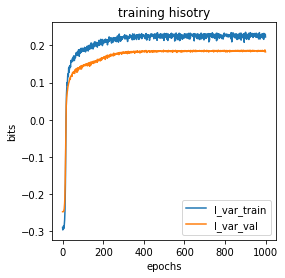

In [32]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
fig.savefig('pngs/Titeseq_MP/history.png',dpi=200,bbox_inches='tight')

In [33]:
#plt.scatter(theta_lc_init.ravel(),gpmap.weights[1].numpy().ravel(),c='blue',s=10)

In [34]:
theta = np.squeeze(gpmap.weights[1].numpy())
theta_df = pd.DataFrame(theta,columns=model.alphabet)

# theta_0 = np.squeeze(gpmap.weights[1].numpy())[0]
# theta_0_df = pd.DataFrame(theta_0,columns=model.alphabet)

# theta_1 = np.squeeze(gpmap.weights[1].numpy())[1]
# theta_1_df = pd.DataFrame(theta_1,columns=model.alphabet)

In [35]:
phi = gpmap.x_to_phi(x_test)

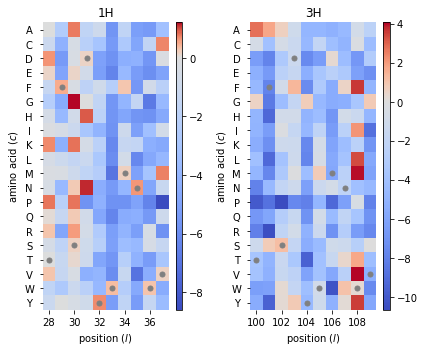

In [36]:
fig, axs = plt.subplots(1,2, figsize=(6,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[0],
                                values=theta_df.loc[0:9].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H')

heatmap_ax, cb = mavenn.heatmap(ax=axs[1],
                                values=theta_df.loc[10:20].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(100,110,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'3H')

fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/GP_map.png',dpi=200,bbox_inches='tight',facecolor='white')

/var/folders/kx/rdhxdz2129n1dd59rnympr580000gp/T/ipykernel_40724/713783321.py:47: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(im)


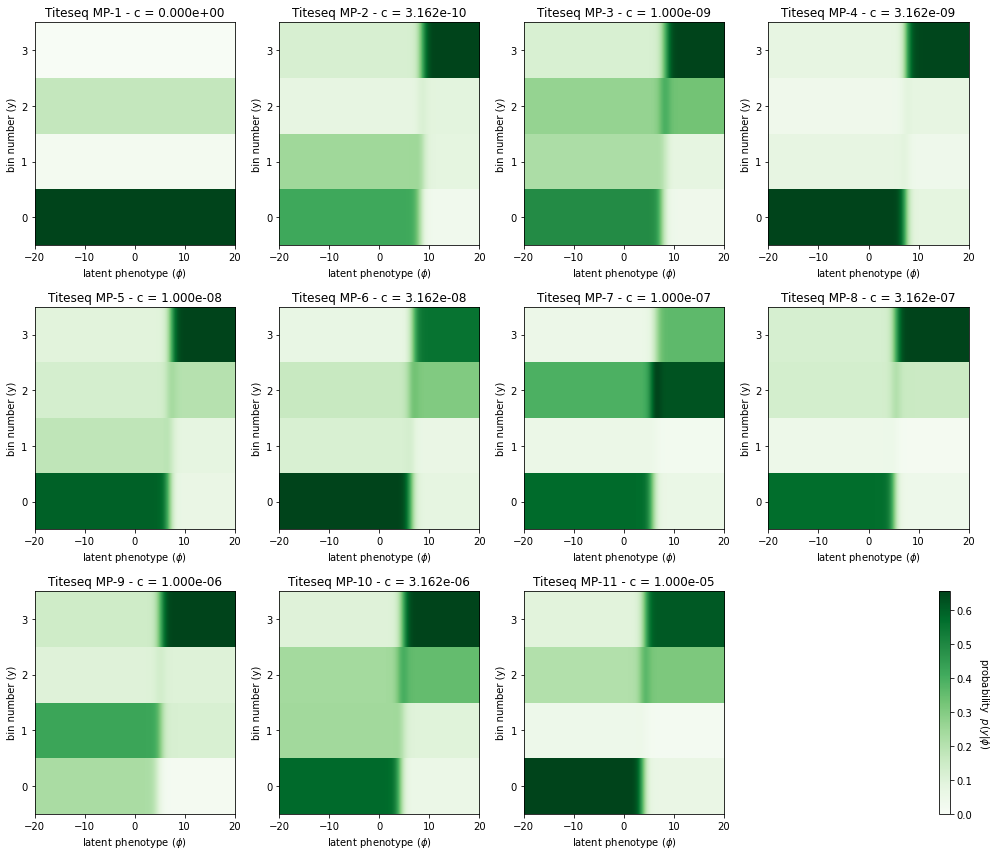

In [37]:
# Create grid in phi space
phi_lim = [-20, 20]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = TiteSeq_mp_list[0].Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(3,4,figsize=[14,12])

mp_counter = 0

for i in range(3):
    for j in range(4):
        

        if mp_counter==11:
            axs[i,j].axis('off')
            break
        measurement_process = TiteSeq_mp_list[order_of_mps[mp_counter]].p_of_y_given_phi(y_all, phi_grid)
        # Right panel: draw measurement process as heatmap
        ax = axs[i,j]

        im = ax.imshow(measurement_process,
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1} - c = {(cs2[order_of_mps[mp_counter]]):.3e}')
        mp_counter+=1
        
#         if mp_counter ==11:
#             cb = plt.colorbar(im,ax=ax)
#             cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")        
        
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

fig.savefig('pngs/Titeseq_MP/MPs.png',dpi=200,bbox_inches='tight')


In [38]:
CDR1H_titeseq_df = pd.DataFrame(np.load('CDR1H.raw.heatmap.npy'),columns=model.alphabet)
CDR3H_titeseq_df = pd.DataFrame(np.load('CDR3H.raw.heatmap.npy'),columns=model.alphabet)

In [39]:
# # Manual Gauge fixing
#from mavenn.src.utils import _x_to_mat

def _x_to_mat1(x, alphabet):
    return (np.array(list(x))[:, np.newaxis] ==
            np.array(alphabet)[np.newaxis, :]).astype(float)

def manual_WT_gauge(theta_lc,L,WT_seq,theta_0=0,model=model):

    C = model.C
    p_lc = _x_to_mat1(WT_seq, list(model.alphabet))

    theta_lclc = np.full(shape=(L, C, L, C), fill_value=np.nan)
    nan_mask_lclc = np.isnan(theta_lclc)
    theta_lclc[nan_mask_lclc] = 0
    _ = np.newaxis

    # Fix 0th order parameter
    fixed_theta_0 = theta_0 \
        + np.sum(p_lc * theta_lc) \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :])

    # Fix 1st order parameters
    fixed_theta_lc = theta_lc \
        - np.sum(theta_lc * p_lc, axis=1)[:, _] \
        + np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=(2, 3)) \
        - np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 2, 3))[:, _]

    # Fix 2nd order parameters
    fixed_theta_lclc = theta_lclc \
        - np.sum(theta_lclc * p_lc[:, :, _, _],
                 axis=1)[:, _, :, :] \
        - np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=3)[:, :, :, _] \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 3))[:, _, :, _]  
    
    return fixed_theta_lc
# np.save('theta_lc_AIE_gf',fixed_theta_lc)

In [40]:
CDR1H_titeseq_WT_gauge = manual_WT_gauge(CDR1H_titeseq_df.values,WT_seq=model.x_stats['consensus_seq'][0:10],L=10)
CDR3H_titeseq_WT_gauge = manual_WT_gauge(CDR3H_titeseq_df.values,WT_seq=model.x_stats['consensus_seq'][10:20],L=10)


In [41]:
theta_lc = gpmap.get_theta(model,gauge='consensus')['theta_lc']
theta_lc_consensus_df = pd.DataFrame(theta_lc,columns=alphabet)

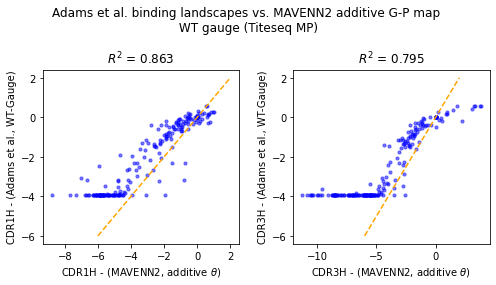

In [42]:
theta_lc_consensus_df.loc[0:9]
fig, axs = plt.subplots(1,2,figsize=(7,4))
ax = axs[0]

Rsq = np.corrcoef(CDR1H_titeseq_WT_gauge.ravel(),theta_lc_consensus_df.loc[0:9].values.ravel())[0,1]**2

lims = [-6,2]
ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.plot(lims,lims,'--',color='orange')
ax.scatter(theta_lc_consensus_df.loc[0:9].values.ravel(),-CDR1H_titeseq_WT_gauge.ravel(),c='blue',s=10,alpha=0.5)
ax.set_ylabel('CDR1H - (Adams et al., WT-Gauge)')
ax.set_xlabel('CDR1H - (MAVENN2, additive $\\theta$)')

ax = axs[1]
Rsq = np.corrcoef(CDR3H_titeseq_WT_gauge.ravel(),theta_lc_consensus_df.loc[10:20].values.ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.plot(lims,lims,'--',color='orange')
ax.scatter(theta_lc_consensus_df.loc[10:20].values.ravel(),-CDR3H_titeseq_WT_gauge.ravel(),c='blue',s=10,alpha=0.5)
ax.set_ylabel('CDR3H - (Adams et al., WT-Gauge)')
ax.set_xlabel('CDR3H - (MAVENN2, additive $\\theta$)')

fig.suptitle('Adams et al. binding landscapes vs. MAVENN2 additive G-P map \n WT gauge (Titeseq MP) ')
fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/Adams_vs_mavenn_GP_map_WT_WT_gauge.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')


In [43]:
# np.save('models/theta_0_TS.npy',model.model.get_weights()[0])
# np.save('models/theta_lc_TS.npy',model.model.get_weights()[1])
# np.save('models/theta_lc_consensus_TS_df.npy', theta_lc_consensus_df.values)

In [44]:
#theta_lc_TS = np.load('models/theta_lc_consensus_TS_df.npy')
theta_lc_DM = np.load('models/theta_lc_consensus_DM_df.npy')



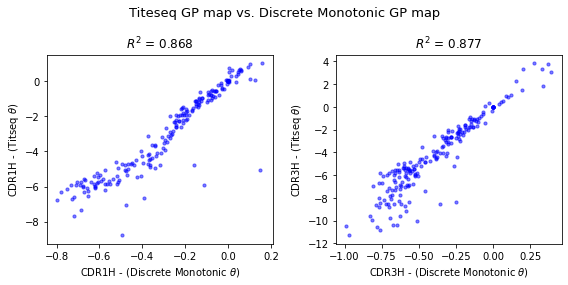

In [45]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

ax = axs[0]

Rsq = np.corrcoef(theta_lc_DM[0:10].ravel(),theta_lc[0:10].ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(theta_lc_DM[0:10].ravel(),theta_lc[0:10].ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR1H - (Discrete Monotonic $\\theta$)')
ax.set_ylabel('CDR1H - (Titseq $\\theta$)')

ax = axs[1]
Rsq = np.corrcoef(theta_lc_DM[10:20].ravel(),theta_lc[10:20].ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(theta_lc_DM[10:20].ravel(),theta_lc[10:20].ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR3H - (Discrete Monotonic $\\theta$)')
ax.set_ylabel('CDR3H - (Titseq $\\theta$)')

fig.suptitle('Titeseq GP map vs. Discrete Monotonic GP map',fontsize=13)
fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/Titeseq_vs_Discrete_mono_GP_map_WT_WT_gauge.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')


### Compute K_D values

In [46]:
#phi = gpmap.x_to_phi(x_test)

#a = TiteSeq_mp_list[0].get_weights()[0][0]

def mu_of_phi(c, 
              a=a,
              phi=phi,
              mu_neg=mu_neg):

    K_a_of_phi = 10**(phi)
    B = 10**(mu_neg)
    A = 10**(a)
    
    mu_of_phi = np.log10(A*(c*K_a_of_phi)/(1+c*K_a_of_phi)+B)
    
    return mu_of_phi


In [47]:
model.x_stats['consensus_seq']

'TFSDYWMNWVGSYYGMDYWG'

In [48]:
def _x_to_mat(x, alphabet):
    return (np.array(list(x))[:, np.newaxis] == alphabet[np.newaxis, :]).astype(float)

In [49]:
model.x_stats['consensus_seq']

'TFSDYWMNWVGSYYGMDYWG'

In [50]:
WT_seq = model.x_stats['consensus_seq']

single_mutants = []

for idx,WT_char in enumerate(WT_seq):
    #print(idx)
    for mutant in model.alphabet:
#         if mutant==WT_seq[idx]:
#             continue
#         else:
        temp_WT_list = list(WT_seq)
        temp_WT_list[idx] = mutant
        single_mutant = ''.join(temp_WT_list)
        single_mutants.append(single_mutant)
            

In [51]:
phi_single_mutants = gpmap.x_to_phi(single_mutants)

In [52]:
Adams_ordering = ['E','D','R','K','H','P','C','Q','N','T','S','W','Y','F','M','L','I','V','A','G']

Text(0.5, 1.0, '1H - (Adams)')

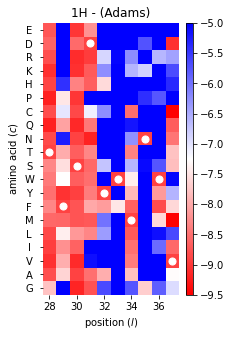

In [53]:
CDR1H_titeseq_df
fig, axs = plt.subplots(1,1, figsize=(2.7,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs,
                                values=(CDR1H_titeseq_df[Adams_ordering].values),
                                alphabet=Adams_ordering,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'white', 's':50},
                                cmap='bwr_r',
                                cbar=True,
                                #clim=[10**-6,10**-5],
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H - (Adams)')

In [54]:
mavenn2_Kd = pd.DataFrame(1/(10**phi_single_mutants.reshape(20,20)),columns=model.alphabet)

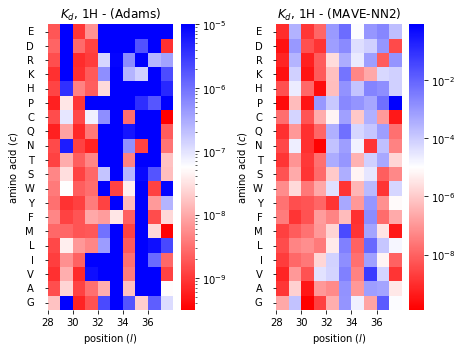

In [55]:
fig, axs = plt.subplots(1,2,figsize=(6.5,5))
from matplotlib.colors import LogNorm

from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=-10**-9, vcenter=10**-6.5, vmax=10**-5)
#pcolormesh(your_data, cmap="coolwarm", norm=divnorm)

data = 10**(CDR1H_titeseq_df[Adams_ordering].values.ravel())
log_norm = LogNorm(vmin=min(data), vmax=max(data))
norm = plt.Normalize(-10**-9.5,10**-5.5,clip=False)
ax = axs[0]
sns.heatmap(10**(CDR1H_titeseq_df[Adams_ordering].values.T),
            ax=ax,
            cmap='bwr_r',
            norm=log_norm
            #norm=divnorm
            #norm=norm
           )

ax.set_xticks(np.arange(0,10,2))
ax.set_xticklabels(np.arange(28,38,2))
ax.tick_params(axis='y', which='major', pad=10)
ax.set_xlabel('position ($l$)')
ax.set_ylabel('amino acid ($c$)')
ax.set_title(f'$K_d$, 1H - (Adams)')
ax.set_yticklabels(Adams_ordering,rotation=0)



ax = axs[1]
data = mavenn2_Kd.loc[0:9][Adams_ordering].values.ravel()
log_norm = LogNorm(vmin=min(data), vmax=max(data))
norm = plt.Normalize(-10**-9.5,10**-5.5,clip=False)

sns.heatmap(mavenn2_Kd.loc[0:9][Adams_ordering].values.T,
            ax=ax,
            cmap='bwr_r',
            norm=log_norm
            #norm=divnorm
            #norm=norm
           )

ax.set_xticks(np.arange(0,10,2))
ax.set_xticklabels(np.arange(28,38,2))
ax.tick_params(axis='y', which='major', pad=10)
ax.set_xlabel('position ($l$)')
ax.set_ylabel('amino acid ($c$)')
ax.set_title(f'$K_d$, 1H - (MAVE-NN2)')
ax.set_yticklabels(Adams_ordering,rotation=0)

fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/Adams_Kd_vs_Mavenn2_Kd_heatmaps.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')


In [56]:
Adams_Kd = pd.concat([CDR1H_titeseq_df,CDR3H_titeseq_df])
temp_null_df = ~pd.isnull(Adams_Kd.replace(-5.00000,np.nan)).reset_index(drop=True)

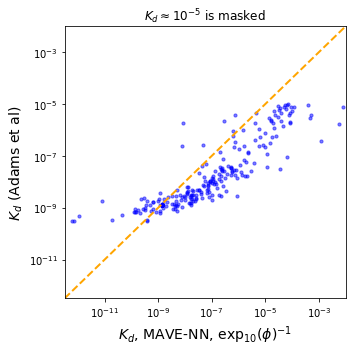

In [57]:
fig, ax = plt.subplots(figsize=(5,5))

lims=[10**-12.5,10**-2]
ax.plot(lims,lims,'--',color='orange',lw=2)

ax.scatter((mavenn2_Kd*temp_null_df).replace(0,np.nan).values.ravel(),
            10**(Adams_Kd.replace(-5.00000,np.nan).reset_index(drop=True).values.ravel()),c='blue',s=10,alpha=0.5)


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel('$K_d$ (Adams et al)',fontsize=14)
ax.set_xlabel('$K_d$, MAVE-NN, ${{\\rm exp}_{10}(\phi)}^{-1}$',fontsize=14)

ax.set_title('$K_d \\approx 10^{-5}$ is masked')
ax.set_ylim(lims)
ax.set_xlim(lims)

fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/Adams_Kd_vs_Mavenn2_Kd_masked.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')

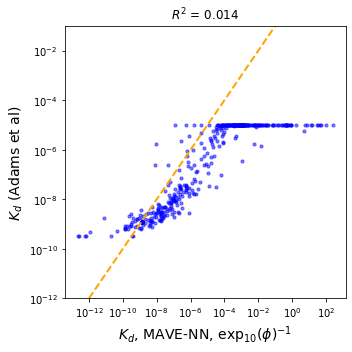

In [58]:
fig, ax = plt.subplots(figsize=(5,5))


lims=[10**-12,10**-1]
ax.plot(lims,lims,'--',color='orange',lw=2)

Rsq = np.corrcoef(1/(10**((phi_single_mutants))),
            10**(pd.concat([CDR1H_titeseq_df,CDR3H_titeseq_df]).values.ravel()))[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(1/10**((phi_single_mutants)),
            10**(pd.concat([CDR1H_titeseq_df,CDR3H_titeseq_df]).values.ravel()),
            color='blue',s=10,alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel('$K_d$ (Adams et al)',fontsize=14)
ax.set_xlabel('$K_d$, MAVE-NN, ${{\\rm exp}_{10}(\phi)}^{-1}$',fontsize=14)
# ax.set_xlim(lims)
# ax.set_ylim(lims)
ax.set_ylim(lims)
fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/Adams_Kd_vs_Mavenn2_Kd.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')


In [59]:
phi_WT = gpmap.x_to_phi(WT_seq)

$K_a(\phi)$ = ${\rm exp}_{10}(\phi)$ \
$K_d$ = ${K_a}^{-1}$

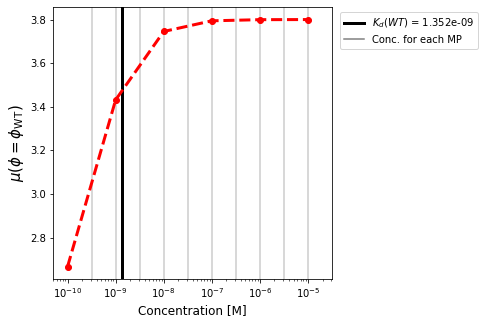

In [60]:
fig, ax = plt.subplots(figsize=(5,5))

cs_ = np.arange(10**-9.5,10**-5,10**(-9.5))
cs_coarse  = np.array([10**(-10),10**(-9),10**(-8),10**(-7),10**(-6),10**(-5)])


# for a_idx in range(len(TiteSeq_mp_list)):
#     as_list.append(TiteSeq_mp_list[a_idx].get_weights()[0][0])

#for a in as_list:
#ax.plot(cs_,(mu_of_phi(c=cs_,a=a,phi=phi_WT)),lw=3,zorder=10,label=f'$A(\phi) = {(10**a):.1e}$')    
ax.plot(cs_coarse,(mu_of_phi(c=cs_coarse,a=a,phi=phi_WT)),'ro--',lw=3,zorder=10)    
ax.set_xlabel('Concentration [M]',fontsize=12)
ax.set_ylabel('$\mu(\phi = \phi_{\\rm WT})$',fontsize=15)

kd_WT = 1/(10**phi_WT)
ax.axvline(kd_WT,color='black',lw=3,label=f'$K_d (WT)$ = {kd_WT:.3e}')
for c in cs2:    
    ax.axvline(c,c='gray',zorder=-10,alpha=0.4)
    
ax.axvline(c,c='gray',label=f'Conc. for each MP',zorder=-10,alpha=0.0)    

leg = ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

ax.set_xlim(min(cs_coarse)/2,10**-4.5)
ax.set_xscale('log')
#ax.set_yscale('log')
fig.savefig('pngs/Titeseq_MP/mu_of_phi_WT_vs_conc.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')

(3.1622776601683795e-10, 9.99975441698445e-06)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


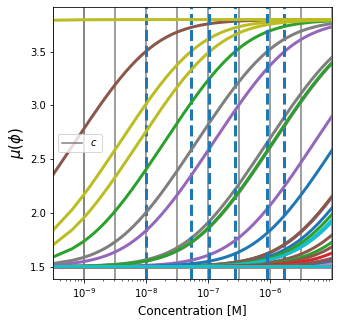

In [61]:
plt.figure(figsize=(5,5))



random_phi_list = np.random.choice(np.arange(0,len(phi)),size=50)

#for _ in random_phi_list:
for _ in random_phi_list:

    #for a in as_list:
    plt.plot(cs_,mu_of_phi(c=cs_,a=a,phi=phi[_]),lw=3)
    plt.axvline(1/(10**phi[_]),ls='--',lw=3)
    
for c in cs2:
    plt.axvline(c,c='gray',zorder=-10)
    
plt.axvline(cs2[-1],c='gray',zorder=-10,label=f'$c$')    
plt.legend()
#plt.plot(cs_,mu_of_phi(c=cs_,phi=phi_WT),'--',lw=4,zorder=10,color='black',label='WT')    
plt.xlabel('Concentration [M]',fontsize=12)
plt.xscale('log')
#plt.yscale('log')
plt.ylabel('$\mu(\phi)$',fontsize=15)
plt.xlim(min(cs_),max(cs_))
#plt.ylim(0,4)